In [1]:
# Import libraries

import pylab as pl
import numpy as np
from astropy.visualization import quantity_support
from astropy import units as u
from astropy import wcs

# pl.rcParams['figure.facecolor']='w'

from spectral_cube import SpectralCube
from pvextractor import extract_pv_slice, Path
import matplotlib.pyplot as plt

import pyspeckit
import astropy.units as u
import astropy.wcs as wcs
import aplpy as aplpy
from astropy.io import fits

from astropy.visualization.wcsaxes import WCSAxes
from astropy.wcs import WCS

from astropy.coordinates import SkyCoord 
from astropy.wcs.utils import skycoord_to_pixel 
from astropy.wcs.utils import pixel_to_skycoord

from matplotlib.patches import Ellipse


In [2]:
# Read all fits files

cube_N2Dp_lowres=SpectralCube.read('/Users/ivarismartinez/Desktop/Research/REU23/ALMA/HOPS164/N2Dp/HOPS164_N2Dp_large_sm_reb.fits')
cube_N2Dp_lowres = cube_N2Dp_lowres.to(u.K).with_spectral_unit(u.km/u.s)

cube_N2Dp=SpectralCube.read('/Users/ivarismartinez/Desktop/Research/REU23/ALMA/HOPS164/N2Dp/HOPS164_N2Dp_Tp12m7m_large_Combine_pbcor.fits')
cube_N2Dp = cube_N2Dp.to(u.K).with_spectral_unit(u.km/u.s)
cube_N2Dp_pvdiagram=SpectralCube.read('/Users/ivarismartinez/Desktop/Research/REU23/ALMA/HOPS164/N2Dp/HOPS164_N2Dp_Tp12m7m_large_Combine_pbcor.fits')

cube_H2CO=SpectralCube.read('/Users/ivarismartinez/Desktop/Research/REU23/ALMA/HOPS164/H2CO/HOPS164_H2CO_Tp12m7m_Combine_pbcor_masked.fits')
cube_H2CO = cube_H2CO.to(u.K).with_spectral_unit(u.km/u.s)
cube_H2CO_pvdiagram=SpectralCube.read('/Users/ivarismartinez/Desktop/Research/REU23/ALMA/HOPS164/H2CO/HOPS164_H2CO_Tp12m7m_Combine_pbcor_masked.fits')

cube_C18O=SpectralCube.read('/Users/ivarismartinez/Desktop/Research/REU23/ALMA/HOPS164/C18O/HOPS164_C18O_Tp12m7m_Combine_pbcor_masked.fits')
cube_C18O = cube_C18O.to(u.K).with_spectral_unit(u.km/u.s)
cube_C18O_pvdiagram=SpectralCube.read('/Users/ivarismartinez/Desktop/Research/REU23/ALMA/HOPS164/C18O/HOPS164_C18O_Tp12m7m_Combine_pbcor_masked.fits')

cube_13CO=SpectralCube.read('/Users/ivarismartinez/Desktop/Research/REU23/ALMA/HOPS164/13CO/HOPS164_13CO_Tp12m7m_Combine_pbcor_masked.fits')
cube_13CO = cube_13CO.to(u.K).with_spectral_unit(u.km/u.s)
cube_13CO_pvdiagram=SpectralCube.read('/Users/ivarismartinez/Desktop/Research/REU23/ALMA/HOPS164/13CO/HOPS164_13CO_Tp12m7m_Combine_pbcor_masked.fits')

cube_12CO=SpectralCube.read('/Users/ivarismartinez/Desktop/Research/REU23/ALMA/HOPS164/CO/HOPS164_CO_Tp12m7m_Combine_pbcor_masked.fits')
cube_12CO.allow_huge_operations = True 
cube_12CO = cube_12CO.to(u.K).with_spectral_unit(u.km/u.s)
cube_12CO_pvdiagram=SpectralCube.read('/Users/ivarismartinez/Desktop/Research/REU23/ALMA/HOPS164/CO/HOPS164_CO_Tp12m7m_Combine_pbcor_masked.fits')
cube_12CO_pvdiagram.allow_huge_operations = True 

cube_robust = '/Users/ivarismartinez/Desktop/Research/REU23/ALMA/HOPS164/Continuum/HOPS-164_cont_robust0.5.pbcor.fits'
cube_robust = SpectralCube.read(cube_robust)

# Continuum
fits_path = "/Users/ivarismartinez/Desktop/Research/REU23/ALMA/HOPS164/Continuum/HOPS-164_Continuum_natural_thres0.4mJy.pbcor.fits"
hdu = fits.open(fits_path)[0]
wcs = WCS(hdu.header).celestial
  

Cube is a Stokes cube, returning spectral cube for I component


In [3]:
# Define contour, path, and beam functions

def plot_contours(fits_file, color, min_level, max_level, number_of_levels, ax):

    gamma = 2.0
    scaled_levels = np.linspace(0, 1, number_of_levels) ** gamma
    levels_continuum = min_level + (max_level - min_level) * scaled_levels
    
    return ax.contour(fits_file, colors=color, levels=levels_continuum, linewidths=0.5)


def find_path2(data, y1, y2, y_iter, x1, x2):
    my_list = []

    for col in range(y1, y2, y_iter):
        valores = []

        for row in data[:, col]:

            for i in range(x1-x2):
                valores.append(i)
                max_value = np.nanmax(valores)
                indices = np.where(data == max_value)
                print(indices)
                i = (indices[1][0], indices[1][0])
                my_list.append(i)

    return print(my_list)

def find_path(data, y1, y2, y_iter, x1, x2):
    my_list = []

    for col in range(y1, y2, y_iter):
        valores = []

        # Grab the vertical slice of data in this column, between rows x1 and x2
        for row in range(x1, x2):
            value = data[row, col]
            valores.append(value)

        # Find the maximum value in the vertical slice
        max_value = np.nanmax(valores)

        # Find where it occurs in the full 2D array
        indices = np.where(data == max_value)
        i = (indices[0][0], indices[1][0])  # (row, col)
        my_list.append(i)

    print(my_list)

def beam(beam_minor, beam_major, beam_pa, beam_position_x, beam_position_y):
    # Set beam location
    beam_x = beam_position_x 
    beam_y = beam_position_y

    # Create the beam ellipse
    return Ellipse(
        (beam_x, beam_y),
        width=beam_major,
        height=beam_minor,
        angle=beam_pa,
        edgecolor='black',
        facecolor='none',
        alpha=0.7,
        zorder=10
    )


In [4]:
# Actual coordinates for center of the protostar (Tobin et. al. 2020)
# marker_coord = SkyCoord("5h37m00.454s", "-6d37m10.48s", frame='icrs')

# Coordinates that work for ALMA
marker_coord = SkyCoord("5h37m00.4307s", "-6d37m10.7s", frame='icrs')
x_marker, y_marker = skycoord_to_pixel(marker_coord, cube_N2Dp.wcs.celestial)

# print(x_marker, y_marker)

# Robust 0.5

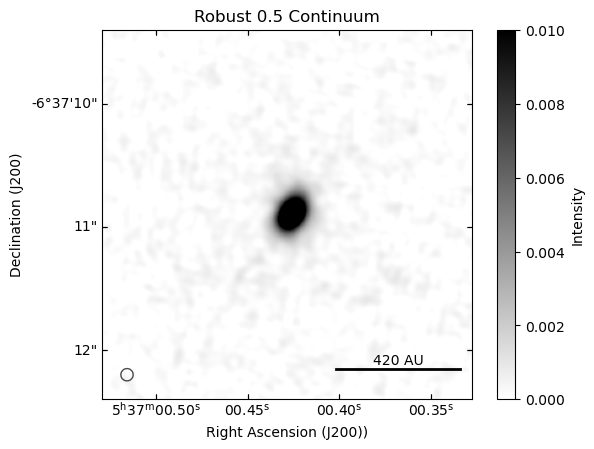

In [5]:
data_robust = cube_robust.hdu.data

fig = plt.figure()
ax = plt.subplot(111, projection=cube_robust.wcs.celestial)
im = ax.imshow(data_robust[0].data, origin='lower', cmap='binary', vmin=0, vmax=0.01)

# Plot contours
# plot_contours(hdu.data, 'white', 0, 0.0015, 5)

# Plot the protostar marker
ax.plot(0, 0, marker='+', color='lime', markersize=10, label='Marker')

# Set labels
ax.set_xlabel('Right Ascension (J200))')
ax.set_ylabel('Declination (J200)')
ax.set_title('Robust 0.5 Continuum')

# Move ticks inside
ax.tick_params(axis='both', direction='in', which='both')

# Add colorbar
plt.colorbar(im, ax=ax, label='Intensity')

# Add beam
beam_continuum = beam(0.10/0.01, 0.10/0.01, -18.29, 420, 340)
ax.add_patch(beam_continuum)

# Set offset limits
ax.set_xlim(400, 700)  
ax.set_ylim(320, 620)

# Set starting point for the scale bar (in arcseconds)
x_start = ax.get_xlim()[0] + 190    # 5" from left
y_start = ax.get_ylim()[0] + 25    # 5" from bottom

# Length of the bar in arcseconds
scale_bar_length = 1/0.01  # arcseconds

# Plot the scale bar
ax.plot([x_start, x_start + scale_bar_length], [y_start, y_start], color='black', linewidth=2)

# Label it
ax.text(x_start + scale_bar_length / 2, y_start + 1.0, "420 AU",
        color='black', ha='center', va='bottom', fontsize=10)

# Saave image
plt.savefig("HOPS164_robust0.5_continnum.pdf", format="pdf", dpi=300, bbox_inches="tight")

# Close imshow
plt.show()

# Continuum

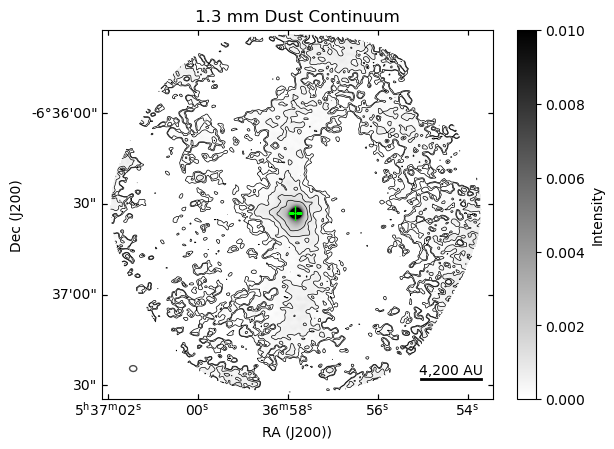

In [101]:
fig = plt.figure()
ax = plt.subplot(111, projection=cube_N2Dp_lowres.wcs.celestial)
im = ax.imshow(hdu.data, origin='lower', cmap='binary', vmin=0, vmax=0.01)

# Plot contours
plot_contours(hdu.data, 'black', 0, 0.0015, 5, ax=ax)

# Add beam
beam_continuum = beam(1.20/0.17, 0.97/0.17, 85.18, 70, 70)
ax.add_patch(beam_continuum)

# Set pixel limits
ax.set_xlim(40, 420)  
ax.set_ylim(40, 400)

# Set starting point for the scale bar (in pixels)
x_start = ax.get_xlim()[0] + 310
y_start = ax.get_ylim()[0] + 20

# Length of the bar in amount of arcseconds (divide by arcseconds per pixel)
scale_bar_length = 10/0.17  # pixels

# Plot the scale bar
ax.plot([x_start, x_start + scale_bar_length], [y_start, y_start], color='black', linewidth=2)

# Label it
ax.text(x_start + scale_bar_length / 2, y_start + 1.5, "4,200 AU",
        color='black', ha='center', va='bottom', fontsize=10)

# Plot the protostar marker
ax.plot(x_marker, y_marker, marker='+', color='lime', markersize=10, label='Marker')

# Move ticks inside
ax.tick_params(axis='both', direction='in', which='both')

# Add colorbar
plt.colorbar(im, ax=ax, label='Intensity')

# Set labels
ax.set_xlabel('RA (J200))')
ax.set_ylabel('Dec (J200)')
ax.set_title('1.3 mm Dust Continuum')

# Save image
# plt.savefig("HOPS164_1.3_continnum.png", format="png", dpi=300, bbox_inches="tight")

# Close imshow
plt.show()

# North-South Emission

# N2D+ (low res)

In [13]:
v_min_N2Dp = 4.5
v_max_N2Dp = 6.5

# Chose channels with emission
slab_N2Dp_lowres = cube_N2Dp_lowres.spectral_slab(v_min_N2Dp*u.km/u.s, v_max_N2Dp*u.km/u.s)

# Create moment 0 map
moment0 = slab_N2Dp_lowres.moment(order=0)

# Access moment 0 data
moment0_N2Dp_lowres = moment0.hdu.data

# find_path2(data_N2Dp_lowres,181,40,-20,80,150)

In [14]:
# path_coords = []

# for y_row in range(181, 40, -20):
    
#     x1_coord = []
#     x2_coord = []

#     for x_value_in_row in range(76, 145, 1):
#         x1 = moment0_N2Dp_lowres[x_value_in_row, y_row]
#         # print(x1)

#         if x1 >= 0.012283502598941147:
#             x1_coord = x_value_in_row
#             # print(x1_coord)
#             break     

#     for x_value_in_row in range(145, 76, -1):
#         x2 = moment0_N2Dp_lowres[x_value_in_row, y_row]
#         # print(x2)

#         if x2 >= 0.012283502598941147:
#             x2_coord = x_value_in_row
#             # print(x2_coord)
#             break
    
#     avg_x_value_in_row = (x1_coord + x2_coord)/2
#     avg_x_coord = (avg_x_value_in_row, y_row)
#     # print(avg_x_coord)

#     path_coords.append(avg_x_coord)
    

# print(path_coords)


# path_coords = []

# for y_row in range(181, 40, -20):
    
#     x_coords = []
    
#     for x_value_in_row in range(76, 145, 1):
#         x = moment0_N2Dp_lowres[x_value_in_row, y_row]
#         # print(x)

#         if x >= 0.006:
#             x_coord = x_value_in_row

#             print(y_row, x)
#             x_coords.append(x_coord)

#     x_max_avg = np.average(x_coords)

#     avg_x_coord = (x_max_avg, y_row)
#     # print(avg_x_coord)

#     path_coords.append(avg_x_coord)
    
# # print(path_coords)

In [15]:
import numpy as np
from scipy.signal import find_peaks

path_coords = []

for y_row in range(181, 40, -20):
    
    x_coords = []
    
    for x_value_in_row in range(76, 145, 1):
        x = moment0_N2Dp_lowres[x_value_in_row, y_row]
        # print(x)
        x_coords.append(x)
    
    # print(x_coords)

    x_max_peaks = find_peaks(x_coords, prominence=0.11)
    print(x_max_peaks[0])

    x_max_avg = np.average(x_max_peaks[0])
    # print(x_max_avg)

    path_coords1 = (x_max_avg, y_row)
    path_coords.append(path_coords1)
    
print(path_coords)

[21 37 51]
[25]
[19]
[25 43]
[39]
[12]
[16 65]
[ 8 29 44 61]
[(36.333333333333336, 181), (25.0, 161), (19.0, 141), (34.0, 121), (39.0, 101), (12.0, 81), (40.5, 61), (35.5, 41)]


In [16]:
# path3 = [(115.5, 181), (101.0, 161), (110.5, 121), (110.5, 101), (112.0, 81), (116.0, 61), (110.5, 41)]
# path2 = [(120, 181), (117, 161), (114, 141), (112, 121), (116, 101), (110, 81), (112, 61), (96, 41)]
# path = [(97, 181), (101, 161), (122, 141), (101, 121), (115, 101), (88, 81), (141, 61), (84, 41)]

# #change pixels to world coordinates
# w = WCS(cube_N2Dp_lowres[0].header)
# w2d = w.celestial  

# my_list2 = [] #world-coordinates
# for i in path3:
#     j = w2d.pixel_to_world(i,0)
#     my_list2.append(j)
# print(my_list2)

# #change world coordinates to pixels
# my_list3 = [] #pixel_coordinates
# for i in my_list2:
#     x, y = w2d.world_to_pixel(i)
#     my_list3.append((x[0], x[1])) 

# print(my_list3)

In [17]:
# path_N2Dp_lowres = Path([(120, 181), (117, 161), (114, 141), (112, 121), (116, 101), (110, 81), (112, 61), (96, 41)]
# ,width=0.5)

# path_N2Dp_lowres = Path([(97, 181), (101, 161), (122, 141), (101, 121), (115, 101), (88, 81), (141, 61), (84, 41)]
# ,width=0.5)

# path_N2Dp_lowres = Path([(103, 0), (103, 1), (103, 2), (103, 3), (103, 4), (103, 5), (103, 6), (103, 7), (103, 8), (103, 9), (103, 10), (103, 11), (103, 12), (103, 13), (103, 14), (103, 15), (103, 16), (103, 17), (103, 18), (103, 19), (103, 20), (103, 21), (103, 22), (110, 23), (113, 24), (115, 25), (117, 26), (118, 27), (119, 28), (121, 29), (122, 30), (123, 31), (124, 32), (125, 33), (126, 34), (126, 35), (127, 36), (127, 37), (127, 38), (128, 39), (131, 40), (131, 41), (89, 42), (90, 43), (89, 44), (49, 45), (48, 46), (47, 47), (47, 48), (47, 49), (90, 50), (45, 51), (89, 52), (44, 53), (44, 54), (43, 55), (43, 56), (43, 57), (43, 58), (42, 59), (65, 60), (65, 61), (88, 62), (88, 63), (112, 64), (120, 65), (123, 66), (122, 67), (121, 68), (120, 69), (119, 70), (119, 71), (118, 72), (117, 73), (117, 74), (116, 75), (117, 76), (118, 77), (119, 78), (119, 79), (114, 80), (110, 81), (110, 82), (110, 83), (110, 84), (111, 85), (112, 86), (112, 87), (112, 88), (112, 89), (113, 90), (113, 91), (114, 92), (115, 93), (115, 94), (115, 95), (116, 96), (116, 97), (116, 98), (116, 99), (116, 100), (116, 101), (115, 102), (113, 103), (110, 104), (109, 105), (108, 106), (108, 107), (108, 108), (108, 109), (108, 110), (108, 111), (108, 112), (109, 113), (109, 114), (109, 115), (110, 116), (111, 117), (112, 118), (112, 119), (112, 120), (111, 121), (111, 122), (111, 123), (111, 124), (110, 125), (111, 126), (111, 127), (111, 128), (111, 129), (112, 130), (112, 131), (113, 132), (113, 133), (114, 134), (114, 135), (114, 136), (115, 137), (115, 138), (114, 139), (114, 140), (114, 141), (114, 142), (114, 143), (114, 144), (114, 145), (115, 146), (116, 147), (116, 148), (117, 149), (118, 150), (119, 151), (120, 152), (120, 153), (120, 154), (120, 155), (118, 156), (117, 157), (117, 158), (117, 159), (117, 160), (117, 161), (92, 162), (91, 163), (67, 164), (67, 165), (42, 166), (42, 167), (42, 168), (43, 169), (43, 170), (43, 171), (44, 172), (45, 173), (90, 174), (47, 175), (47, 176), (47, 177), (48, 178), (49, 179), (89, 180), (89, 181), (131, 182), (131, 183), (128, 184), (127, 185), (127, 186), (127, 187), (126, 188), (125, 189), (124, 190), (123, 191), (122, 192), (120, 193), (119, 194), (117, 195), (115, 196), (112, 197), (106, 198), (103, 199), (103, 200), (103, 201), (103, 202), (103, 203), (103, 204), (103, 205), (103, 206), (103, 207), (103, 208), (103, 209), (103, 210), (103, 211), (103, 212), (103, 213), (103, 214), (103, 215), (103, 216), (103, 217), (103, 218), (103, 219), (103, 220), (103, 221), (103, 222), (103, 223)]
# , width=0.5)

In [18]:
path_N2Dp_lowres = Path(path_coords, width=0.5)

Setting the 'color' property will override the edgecolor or facecolor properties.


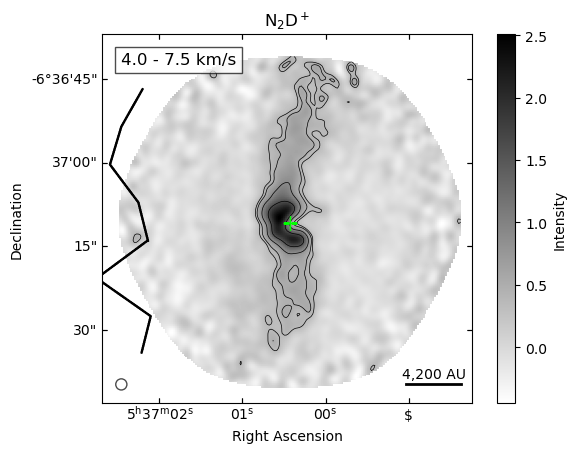

In [25]:
fig = plt.figure()
ax = plt.subplot(111, projection=cube_N2Dp_lowres.wcs.celestial)

im = ax.imshow(moment0_N2Dp_lowres, origin='lower', cmap='binary')

# Plot contours
plot_contours(moment0_N2Dp_lowres, color='black', min_level=0.35, max_level=2.5, number_of_levels=5, ax=ax)

# Plot the protostar marker
ax.plot(114, 110, marker='+', color='lime', markersize=10, label='Marker')

# Add labels
ax.set_xlabel('Right Ascension')
ax.set_ylabel('Declination')
ax.set_title(r'N$_2$D$^+$')

# Add velocity label in the top left of the subplot
ax.text(0.05, 0.95, f"{v_min_N2Dp:.1f} - {v_max_N2Dp:.1f} km/s", transform=ax.transAxes, fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.7))

# Move ticks inside
ax.tick_params(axis='both', direction='in', which='both')

# Add colorbar
plt.colorbar(im, ax=ax, label='Intensity')

# Add it to the plot
beam_N2Dp = beam(2/0.34, 2/0.34, 0, 25, 25) #beam arcseconds times pixel arcseconds for the fits file
ax.add_patch(beam_N2Dp)

# Set offset limits
ax.set_xlim(15, 210) 
ax.set_ylim(15, 210)

# Set starting point for the scale bar (in arcseconds)
x_start = ax.get_xlim()[0] + 160    
y_start = ax.get_ylim()[0] + 10  

# Length of the bar in arcseconds
scale_bar_length = 10/0.34 # pixels (10 arcseconds in the image)

# Plot the scale bar
ax.plot([x_start, x_start + scale_bar_length], [y_start, y_start], color='black', linewidth=2)

# Label it
ax.text(x_start + scale_bar_length / 2, y_start + 1.5, "4,200 AU",
        color='black', ha='center', va='bottom', fontsize=10)

path_N2Dp_lowres.show_on_axis(ax, spacing=1, color='black')

# Save image
# plt.savefig("HOPS164_N2Dp_lowres_contour_map.png", format="png", dpi=300, bbox_inches="tight")

# Close imshow
plt.show()

# N2D+ (high-res)

In [26]:
v_min_N2Dp = 4.0
v_max_N2Dp = 7.5

# Chose channels with emission
slab_N2Dp = cube_N2Dp.spectral_slab(v_min_N2Dp*u.km/u.s, v_max_N2Dp*u.km/u.s)
slab_N2Dp_pvdiagram = cube_N2Dp_pvdiagram.spectral_slab(v_min_N2Dp*u.km/u.s, v_max_N2Dp*u.km/u.s)

# Create moment 0 map
moment0 = slab_N2Dp.moment(order=0)

# Access moment 0 data
data_N2Dp = moment0.hdu.data

In [27]:
path_most_emission = Path([(240.5, 362.5), (234.5, 322.5), (228.5, 282.5), (224.5, 242.5), (232.5, 202.5), (239.5, 162.5), (234.5, 122.5), (192.5, 82.5)]
,width=0.5)

Setting the 'color' property will override the edgecolor or facecolor properties.


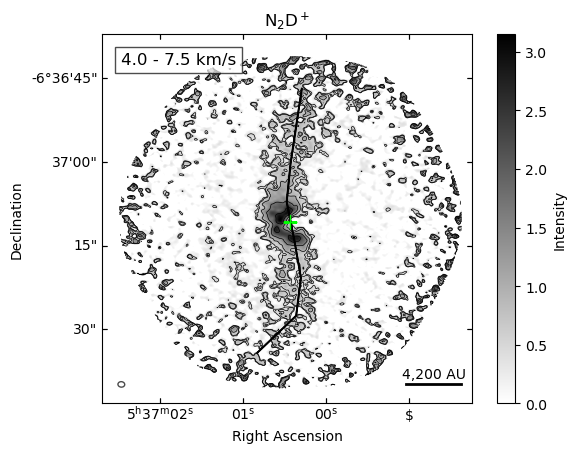

In [28]:
fig = plt.figure()
ax = pl.plt.subplot(111, projection=cube_N2Dp.wcs.celestial)
im = ax.imshow(data_N2Dp, origin='lower', cmap='binary', vmin=0)

# Plot contours
plot_contours(data_N2Dp, color='black', min_level=0.4, max_level=2.5, number_of_levels=5, ax=ax)

# Plot the protostar marker
ax.plot(x_marker, y_marker, marker='+', color='lime', markersize=10, label='Marker')

# Add labels
ax.set_xlabel('Right Ascension')
ax.set_ylabel('Declination')
ax.set_title(r'N$_2$D$^+$')

# Add velocity label in the top left of the subplot
ax.text(0.05, 0.95, f"{v_min_N2Dp:.1f} - {v_max_N2Dp:.1f} km/s", transform=ax.transAxes, fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.7))

# Move ticks inside
ax.tick_params(axis='both', direction='in', which='both')

# Add colorbar
plt.colorbar(im, ax=ax, label='Intensity')

# Add it to the plot
beam_N2Dp = beam(1.22/0.17, 0.98/0.17, 84.98, 50, 50) #beam arcseconds times pixel arcseconds for the fits file
ax.add_patch(beam_N2Dp)

# Set offset limits
ax.set_xlim(30, 420) 
ax.set_ylim(30, 420)

# Set starting point for the scale bar (in arcseconds)
x_start = ax.get_xlim()[0] + 320    
y_start = ax.get_ylim()[0] + 20  

# Length of the bar in arcseconds
scale_bar_length = 10/0.17 # pixels (10 arcseconds in the image)

# Plot the scale bar
ax.plot([x_start, x_start + scale_bar_length], [y_start, y_start], color='black', linewidth=2)

# Label it
ax.text(x_start + scale_bar_length / 2, y_start + 3, "4,200 AU",
        color='black', ha='center', va='bottom', fontsize=10)

path_most_emission.show_on_axis(ax, spacing=1, color='black')

# Save image
# plt.savefig("HOPS164_N2Dp_contour_map_with_pvdiagram_path.png", format="png", dpi=300, bbox_inches="tight")

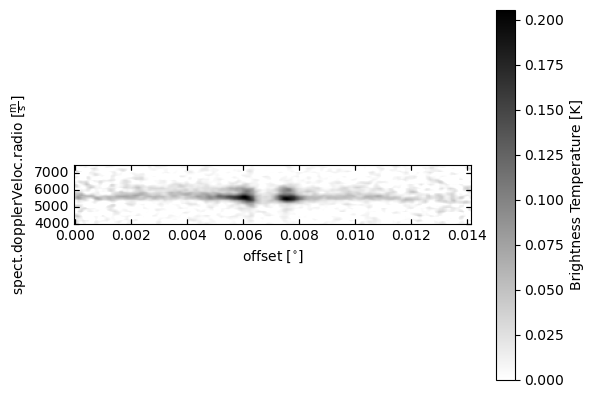

In [29]:
N2Dp_pvdiagram = extract_pv_slice(slab_N2Dp_pvdiagram, path_most_emission, spacing=1) 

ax=pl.plt.axes(111,projection=wcs.WCS(N2Dp_pvdiagram.header))
im=ax.imshow(N2Dp_pvdiagram.data, cmap='binary', vmin=0)
cb=pl.colorbar(mappable=im)
cb.set_label('Brightness Temperature [K]')

# Move ticks inside
ax.tick_params(axis='both', direction='in', which='both')

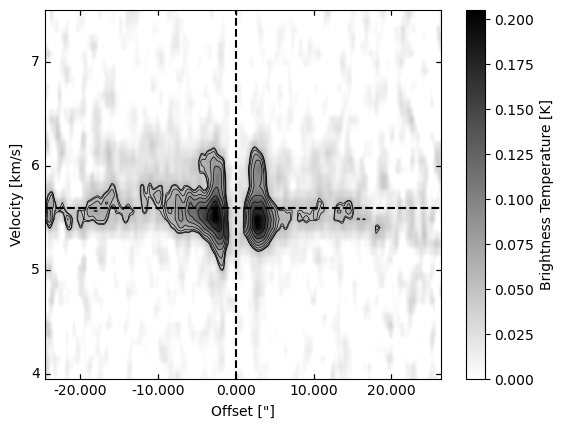

In [30]:
# Get the data array from the PV diagram
data = N2Dp_pvdiagram.data
ny, nx = data.shape
# print(nx, ny)

# Define offset and velocity axes
x_axis = np.arange(data.shape[1])  # Offset in pixels
y_axis = np.linspace(v_min_N2Dp, v_max_N2Dp, data.shape[0])  # Velocity in km/s

# Center of the offset axis (pixel 145 = 0 arcsec)
center_index = 144 # center of pvdiagram

# Update WCS header to match that center
pv_header_centered = N2Dp_pvdiagram.header.copy()
pv_header_centered['CRPIX1'] = center_index + 1  # 1-based FITS indexing
pv_header_centered['CRVAL1'] = 0.0  # Center at 0 arcsec

ww = wcs.WCS(pv_header_centered)

# Plot
ax = pl.plt.axes(111, projection=ww)
im = ax.imshow(N2Dp_pvdiagram.data, aspect='auto', cmap='binary', vmin=0)
cb = pl.colorbar(mappable=im)
cb.set_label('Brightness Temperature [K]')

ax0 = ax.coords[0]
ax0.set_format_unit(u.arcsec, decimal=True, show_decimal_unit=True)
ax1 = ax.coords[1]
ax1.set_format_unit(u.km/u.s, decimal=True, show_decimal_unit=True)

ax.set_ylabel('Velocity [km/s]')
ax.set_xlabel('Offset ["]')
ax.tick_params(axis='both', direction='in', which='both')

plot_contours(N2Dp_pvdiagram.data, 'black', 0.05, 0.2, 9, ax)

# Add guide lines
x0_pix = nx / 2 - 5.5
ax.axvline(x=x0_pix, color='black', linestyle='--', label='0″ Offset')

velocity_mps = 5.6 * 1000 # kilometers
x_center = nx // 2
y56_pix = ww.wcs_world2pix([[ww.wcs_pix2world([[x_center, 0]], 0)[0][0], velocity_mps]], 0)[0][1]
ax.axhline(y=y56_pix, color='black', linestyle='--', label='5.6 km/s')


Setting the 'color' property will override the edgecolor or facecolor properties.


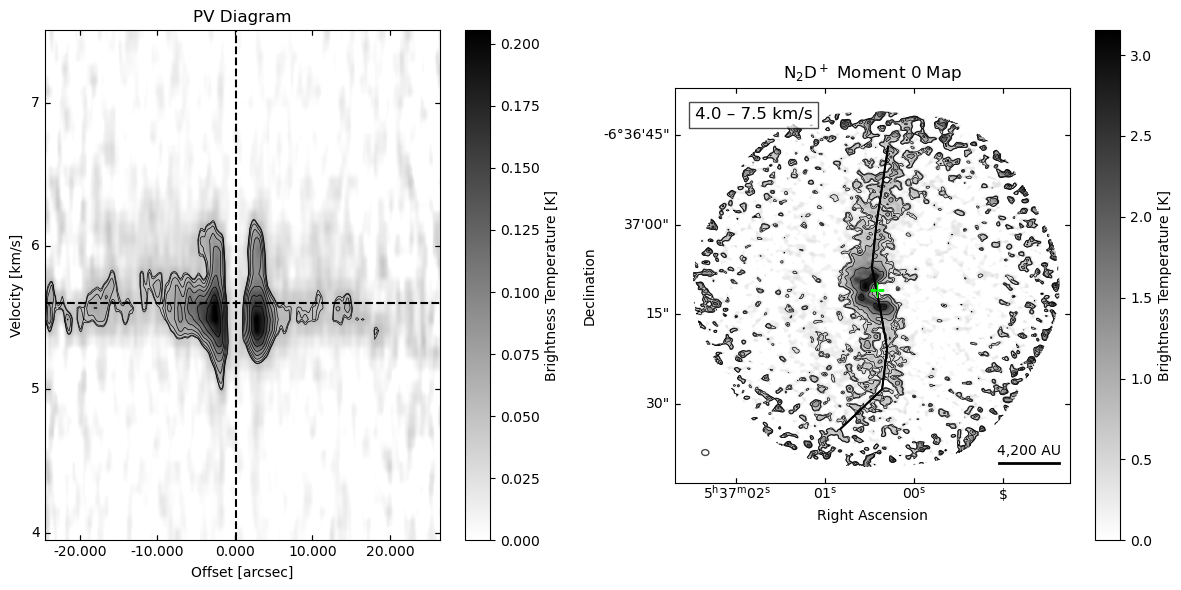

In [32]:
fig = plt.figure(figsize=(12, 6))

# === PV Diagram (ax1) ===
ax1 = fig.add_subplot(1, 2, 1, projection=ww)
im1 = ax1.imshow(N2Dp_pvdiagram.data, aspect='auto', cmap='binary', vmin=0, origin='lower')

ax0 = ax1.coords[0]
ax0.set_format_unit(u.arcsec, decimal=True, show_decimal_unit=True)
ax00 = ax1.coords[1]
ax00.set_format_unit(u.km/u.s, decimal=True, show_decimal_unit=True)

ax1.set_xlabel('Offset [arcsec]')
ax1.set_ylabel('Velocity [km/s]')
ax1.set_title('PV Diagram')
ax1.tick_params(axis='both', direction='in', which='both')

cb1 = plt.colorbar(im1, ax=ax1)
cb1.set_label('Brightness Temperature [K]')

plot_contours(N2Dp_pvdiagram.data, 'black', 0.05, 0.2, 9, ax1)

# Add guide lines
ax1.axvline(x=x0_pix, color='black', linestyle='--', label='0″ Offset')
ax1.axhline(y=y56_pix, color='black', linestyle='--', label='5.6 km/s')

# === Moment 0 Map (ax2) ===
ax2 = fig.add_subplot(1, 2, 2, projection=cube_N2Dp_pvdiagram.wcs.celestial)
im2 = ax2.imshow(data_N2Dp, origin='lower', cmap='binary', vmin=0)
ax2.tick_params(axis='both', direction='in', which='both')

# Colorbar
cb2 = plt.colorbar(im2, ax=ax2)
cb2.set_label('Brightness Temperature [K]')

# Plot contours on ax2
plot_contours(data_N2Dp, color='black', min_level=0.4, max_level=2.5, number_of_levels=5, ax=ax2)

# Labels
ax2.set_xlabel('Right Ascension')
ax2.set_ylabel('Declination')
ax2.set_title(r'N$_2$D$^+$ Moment 0 Map')

# Add velocity label
ax2.text(0.05, 0.95, f"{v_min_N2Dp:.1f} – {v_max_N2Dp:.1f} km/s", transform=ax2.transAxes, fontsize=12,
         verticalalignment='top', bbox=dict(facecolor='white', alpha=0.7))

# Add beam
beam_N2Dp = beam(1.22/0.17, 0.98/0.17, 84.98, 60, 60)  # use actual beam if available
ax2.add_patch(beam_N2Dp)

# Set limits (adjust as needed based on real image size)
ax2.set_xlim(30, 420) 
ax2.set_ylim(30, 420)

# Scale bar setup
scale_bar_length_pix = 10 / 0.17  # pixels for 10 arcsec
x_start = ax2.get_xlim()[0] + 320    
y_start = ax2.get_ylim()[0] + 20  

ax2.plot([x_start, x_start + scale_bar_length_pix], [y_start, y_start], color='black', linewidth=2)
ax2.text(x_start + scale_bar_length_pix / 2, y_start + 5, "4,200 AU", color='black', ha='center', va='bottom', fontsize=10)

# Path overlay
path_most_emission.show_on_axis(ax2, spacing=1, color='black')

# Plot marker
ax2.plot(229, 220, marker='+', color='lime', markersize=10, label='Marker')

plt.tight_layout()
plt.show()


# H2CO

In [33]:
# Chose channels with emission
v_min_H2CO = 4.0
v_max_H2CO = 7.5
slab_H2CO = cube_H2CO.spectral_slab(v_min_H2CO*u.km/u.s, v_max_H2CO*u.km/u.s)
slab_H2CO_pvdiagram = cube_H2CO_pvdiagram.spectral_slab(v_min_H2CO*u.km/u.s, v_max_H2CO*u.km/u.s)

# Create moment 0 map
moment0 = slab_H2CO.moment(order=0)

# Access moment 0 data
data_H2CO = moment0.hdu.data

Setting the 'color' property will override the edgecolor or facecolor properties.


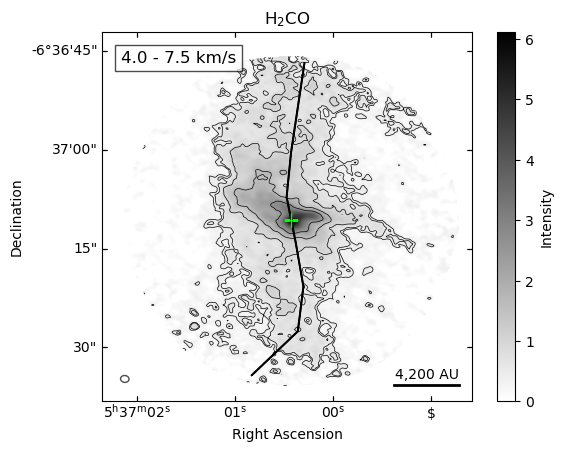

In [36]:
fig = plt.figure()
ax = pl.plt.subplot(111, projection=cube_H2CO.wcs.celestial)
im = ax.imshow(data_H2CO, origin='lower', cmap='binary', vmin=0)

# Plot contours
plot_contours(data_H2CO, color='black', min_level=0.4, max_level=2.5, number_of_levels=5, ax=ax)

# Plot the protostar marker
ax.plot(x_marker, y_marker, marker='+', color='lime', markersize=10, label='Marker')

# Add labels
ax.set_xlabel('Right Ascension')
ax.set_ylabel('Declination')
ax.set_title(r'H$_2$CO')

# Add velocity label in the top left of the subplot
ax.text(0.05, 0.95, f"{v_min_H2CO:.1f} - {v_max_H2CO:.1f} km/s", transform=ax.transAxes, fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.7))

# Move ticks inside
ax.tick_params(axis='both', direction='in', which='both')

# Add colorbar
plt.colorbar(im, ax=ax, label='Intensity')

# Add it to the plot
beam_H2CO = beam(1.29/0.17, 1.04/0.17, 83.63, 80, 80) #beam arcseconds times pixel arcseconds for the fits file
ax.add_patch(beam_H2CO)

# Set offset limits
ax.set_xlim(60, 390) 
ax.set_ylim(60, 390)

# Set starting point for the scale bar (in arcseconds)
x_start = ax.get_xlim()[0] + 260
y_start = ax.get_ylim()[0] + 15

# Length of the bar in arcseconds
scale_bar_length = 10/0.17 # pixels (10 arcseconds in the image)

# Plot the scale bar
ax.plot([x_start, x_start + scale_bar_length], [y_start, y_start], color='black', linewidth=2)

# Label it
ax.text(x_start + scale_bar_length / 2, y_start + 3, "4,200 AU",
        color='black', ha='center', va='bottom', fontsize=10)

path_most_emission.show_on_axis(ax, spacing=1, color='black')

# Save image
# plt.savefig("HOPS164_H2CO_contour_map_with_pvdiagram_path.png", format="png", dpi=300, bbox_inches="tight")

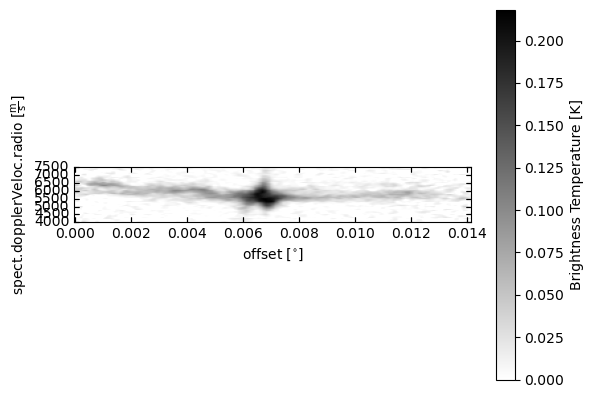

In [37]:
H2CO_pvdiagram = extract_pv_slice(slab_H2CO_pvdiagram, path_most_emission, spacing=1) 

ax=pl.plt.axes(111,projection=wcs.WCS(H2CO_pvdiagram.header))
im=ax.imshow(H2CO_pvdiagram.data, cmap='binary', vmin=0)
cb=pl.colorbar(mappable=im)
cb.set_label('Brightness Temperature [K]')

# Move ticks inside
ax.tick_params(axis='both', direction='in', which='both')

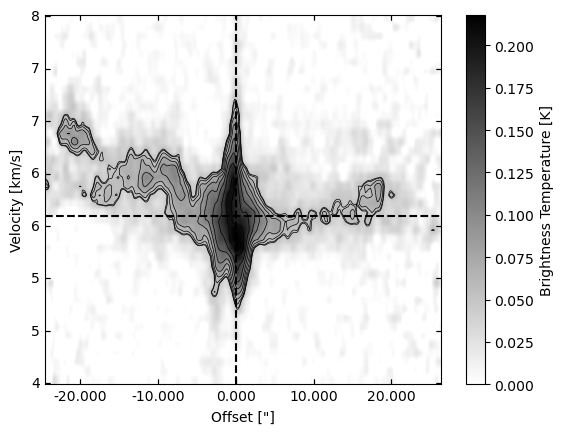

In [38]:
# Get the data array from the PV diagram
data = H2CO_pvdiagram.data
ny, nx = data.shape

# Define offset and velocity axes
x_axis = np.arange(data.shape[1])  # Offset in pixels
y_axis = np.linspace(v_min_H2CO, v_max_H2CO, data.shape[0])  # Velocity in km/s

# Center of the offset axis (pixel 145 = 0 arcsec)
center_index = 144 # center of pvdiagram

# Update WCS header to match that center
pv_header_centered = H2CO_pvdiagram.header.copy()
pv_header_centered['CRPIX1'] = center_index + 1  # 1-based FITS indexing
pv_header_centered['CRVAL1'] = 0.0  # Center at 0 arcsec

ww = wcs.WCS(pv_header_centered)

# Plot
ax = pl.plt.axes(111, projection=ww)
im = ax.imshow(H2CO_pvdiagram.data, aspect='auto', cmap='binary', vmin=0)
cb = pl.colorbar(mappable=im)
cb.set_label('Brightness Temperature [K]')

ax0 = ax.coords[0]
ax0.set_format_unit(u.arcsec, decimal=True, show_decimal_unit=True)
ax1 = ax.coords[1]
ax1.set_format_unit(u.km/u.s, decimal=True, show_decimal_unit=True)

ax.set_ylabel('Velocity [km/s]')
ax.set_xlabel('Offset ["]')
ax.tick_params(axis='both', direction='in', which='both')

plot_contours(H2CO_pvdiagram.data, 'black', 0.05, 0.2, 9, ax=ax)

# Add guide lines
x0_pix = nx / 2 - 5.5
ax.axvline(x=x0_pix, color='black', linestyle='--', label='0″ Offset')

velocity_mps = 5.6 * 1000 # kilometers
x_center = nx // 2
y56_pix = ww.wcs_world2pix([[ww.wcs_pix2world([[x_center, 0]], 0)[0][0], velocity_mps]], 0)[0][1]
ax.axhline(y=y56_pix, color='black', linestyle='--', label='5.6 km/s')


Setting the 'color' property will override the edgecolor or facecolor properties.


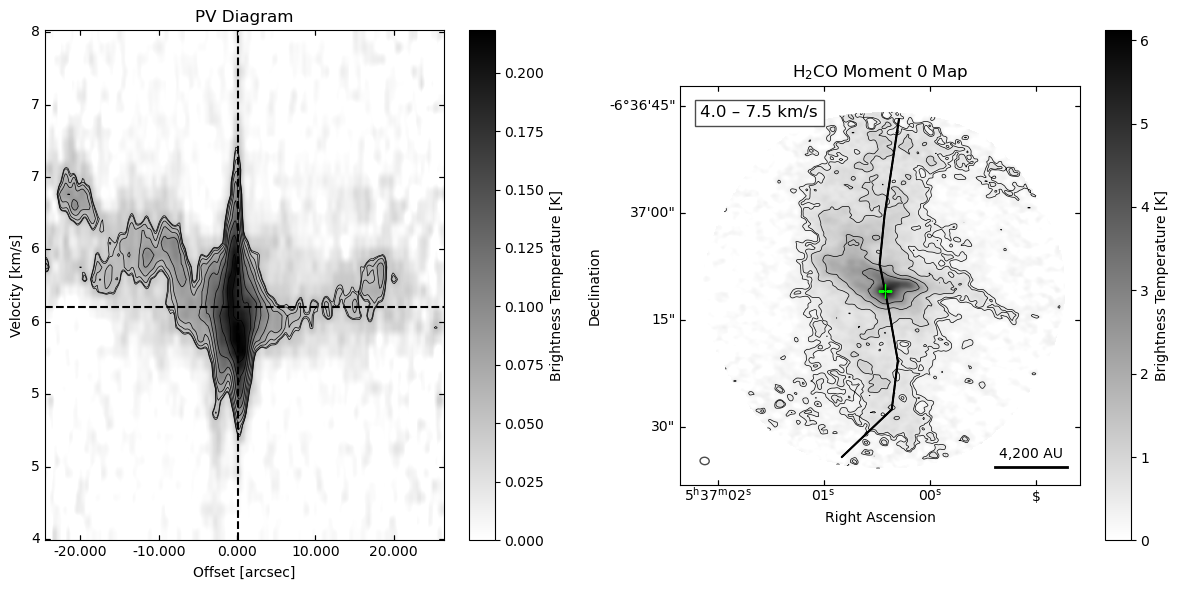

In [40]:
fig = plt.figure(figsize=(12, 6))

# === PV Diagram (ax1) ===
ax1 = fig.add_subplot(1, 2, 1, projection=ww)
im1 = ax1.imshow(H2CO_pvdiagram.data, aspect='auto', cmap='binary', vmin=0, origin='lower')

ax0 = ax1.coords[0]
ax0.set_format_unit(u.arcsec, decimal=True, show_decimal_unit=True)
ax00 = ax1.coords[1]
ax00.set_format_unit(u.km/u.s, decimal=True, show_decimal_unit=True)

ax1.set_xlabel('Offset [arcsec]')
ax1.set_ylabel('Velocity [km/s]')
ax1.set_title('PV Diagram')
ax1.tick_params(axis='both', direction='in', which='both')

cb1 = plt.colorbar(im1, ax=ax1)
cb1.set_label('Brightness Temperature [K]')

plot_contours(H2CO_pvdiagram.data, 'black', 0.05, 0.2, 9, ax1)

# === Moment 0 Map (ax2) ===
ax2 = fig.add_subplot(1, 2, 2, projection=cube_H2CO_pvdiagram.wcs.celestial)
im2 = ax2.imshow(data_H2CO, origin='lower', cmap='binary', vmin=0)
ax2.tick_params(axis='both', direction='in', which='both')

# Add guide lines
ax1.axvline(x=x0_pix, color='black', linestyle='--', label='0″ Offset')
ax1.axhline(y=y56_pix, color='black', linestyle='--', label='5.6 km/s')

# Colorbar
cb2 = plt.colorbar(im2, ax=ax2)
cb2.set_label('Brightness Temperature [K]')

# Plot contours on ax2
plot_contours(data_H2CO, color='black', min_level=0.4, max_level=2.5, number_of_levels=5, ax=ax2)

# Labels
ax2.set_xlabel('Right Ascension')
ax2.set_ylabel('Declination')
ax2.set_title(r'H$_2$CO Moment 0 Map')

# Add velocity label
ax2.text(0.05, 0.95, f"{v_min_H2CO:.1f} – {v_max_H2CO:.1f} km/s", transform=ax2.transAxes, fontsize=12,
         verticalalignment='top', bbox=dict(facecolor='white', alpha=0.7))

# Add beam
beam_H2CO = beam(1.29/0.17, 1.04/0.17, 83.63, 80, 80) #beam arcseconds times pixel arcseconds for the fits file
ax2.add_patch(beam_H2CO)

# Set limits (adjust as needed based on real image size)
ax2.set_xlim(60, 390) 
ax2.set_ylim(60, 390)

# Scale bar setup
scale_bar_length_pix = 10 / 0.17  # pixels for 10 arcsec
x_start = ax2.get_xlim()[0] + 260  
y_start = ax2.get_ylim()[0] + 15

ax2.plot([x_start, x_start + scale_bar_length_pix], [y_start, y_start], color='black', linewidth=2)
ax2.text(x_start + scale_bar_length_pix / 2, y_start + 5, "4,200 AU", color='black', ha='center', va='bottom', fontsize=10)

# Path overlay
path_most_emission.show_on_axis(ax2, spacing=1, color='black')

# Plot marker
ax2.plot(229, 220, marker='+', color='lime', markersize=10, label='Marker')

plt.tight_layout()
plt.show()

# C18O

In [41]:
# Chose channels with emission
v_min_C18O = 4.0
v_max_C18O = 7.5
slab_C18O = cube_C18O.spectral_slab(v_min_C18O*u.km/u.s, v_max_C18O*u.km/u.s)
slab_C18O_pvdiagram = cube_C18O_pvdiagram.spectral_slab(v_min_C18O*u.km/u.s, v_max_C18O*u.km/u.s)

# Create moment 0 map
moment0 = slab_C18O.moment(order=0)

# Access moment 0 data
data_C18O = moment0.hdu.data

Setting the 'color' property will override the edgecolor or facecolor properties.


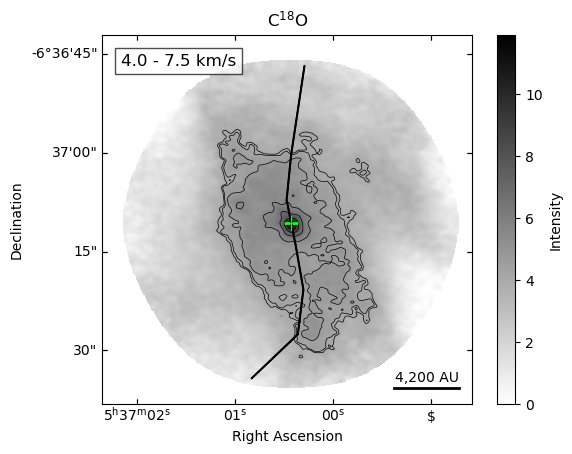

In [42]:
fig = plt.figure()
ax = pl.plt.subplot(111, projection=cube_C18O.wcs.celestial)
im = ax.imshow(data_C18O, origin='lower', cmap='binary', vmin=0)

# Plot contours
plot_contours(data_C18O, color='black', min_level=4, max_level=15, number_of_levels=9, ax=ax)

# Plot the protostar marker
ax.plot(x_marker, y_marker, marker='+', color='lime', markersize=10, label='Marker')

# Add labels
ax.set_xlabel('Right Ascension')
ax.set_ylabel('Declination')
ax.set_title(r'C$^{18}$O')

# Add velocity label in the top left of the subplot
ax.text(0.05, 0.95, f"{v_min_C18O:.1f} - {v_max_C18O:.1f} km/s", transform=ax.transAxes, fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.7))

# Move ticks inside
ax.tick_params(axis='both', direction='in', which='both')

# Add colorbar
plt.colorbar(im, ax=ax, label='Intensity')

# Add beam
beam_C18O = beam(1.30/0.17, 1.03/0.17, 85.77, 80, 80) #beam arcseconds times pixel arcseconds for the fits file
ax2.add_patch(beam_C18O)

# Set offset limits
ax.set_xlim(60, 390) 
ax.set_ylim(60, 390)

# Set starting point for the scale bar (in arcseconds)
x_start = ax.get_xlim()[0] + 260
y_start = ax.get_ylim()[0] + 15

# Length of the bar in arcseconds
scale_bar_length = 10/0.17 # pixels (10 arcseconds in the image)

# Plot the scale bar
ax.plot([x_start, x_start + scale_bar_length], [y_start, y_start], color='black', linewidth=2)

# Label it
ax.text(x_start + scale_bar_length / 2, y_start + 3, "4,200 AU",
        color='black', ha='center', va='bottom', fontsize=10)

path_most_emission.show_on_axis(ax, spacing=1, color='black')

# Save image
# plt.savefig("HOPS164_C18O_contour_map_with_pvdiagram_path.png", format="png", dpi=300, bbox_inches="tight")

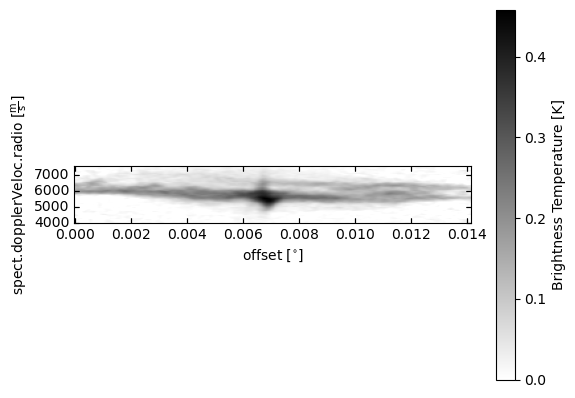

In [43]:
C18O_pvdiagram = extract_pv_slice(slab_C18O_pvdiagram, path_most_emission, spacing=1) 

ax=pl.plt.axes(111,projection=wcs.WCS(C18O_pvdiagram.header))
im=ax.imshow(C18O_pvdiagram.data, cmap='binary', vmin=0)
cb=pl.colorbar(mappable=im)
cb.set_label('Brightness Temperature [K]')

# Move ticks inside
ax.tick_params(axis='both', direction='in', which='both')

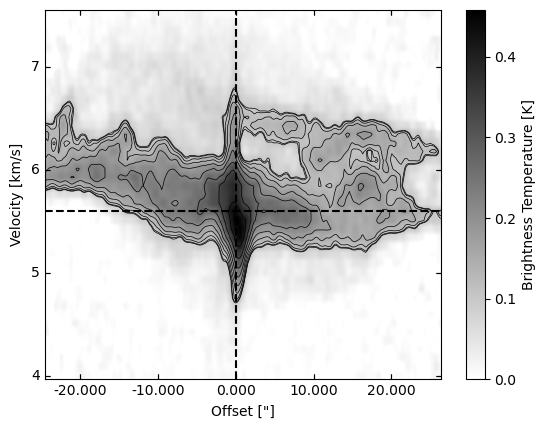

In [44]:
# Get the data array from the PV diagram
data = C18O_pvdiagram.data
ny, nx = data.shape

# Define offset and velocity axes
x_axis = np.arange(data.shape[1])  # Offset in pixels
y_axis = np.linspace(v_min_C18O, v_max_C18O, data.shape[0])  # Velocity in km/s

# Center of the offset axis (pixel 145 = 0 arcsec)
center_index = 144 # center of pvdiagram

# Update WCS header to match that center
pv_header_centered = C18O_pvdiagram.header.copy()
pv_header_centered['CRPIX1'] = center_index + 1  # 1-based FITS indexing
pv_header_centered['CRVAL1'] = 0.0  # Center at 0 arcsec

ww = wcs.WCS(pv_header_centered)

# Plot
ax = pl.plt.axes(111, projection=ww)
im = ax.imshow(C18O_pvdiagram.data, aspect='auto', cmap='binary', vmin=0)
cb = pl.colorbar(mappable=im)
cb.set_label('Brightness Temperature [K]')

ax0 = ax.coords[0]
ax0.set_format_unit(u.arcsec, decimal=True, show_decimal_unit=True)
ax1 = ax.coords[1]
ax1.set_format_unit(u.km/u.s, decimal=True, show_decimal_unit=True)

ax.set_ylabel('Velocity [km/s]')
ax.set_xlabel('Offset ["]')
ax.tick_params(axis='both', direction='in', which='both')

plot_contours(C18O_pvdiagram.data, 'black', 0.1, 0.4, 9, ax=ax)

# Add guide lines
x0_pix = nx / 2 - 5.5
ax.axvline(x=x0_pix, color='black', linestyle='--', label='0″ Offset')

velocity_mps = 5.6 * 1000 # kilometers
x_center = nx // 2
y56_pix = ww.wcs_world2pix([[ww.wcs_pix2world([[x_center, 0]], 0)[0][0], velocity_mps]], 0)[0][1]
ax.axhline(y=y56_pix, color='black', linestyle='--', label='5.6 km/s')

Setting the 'color' property will override the edgecolor or facecolor properties.


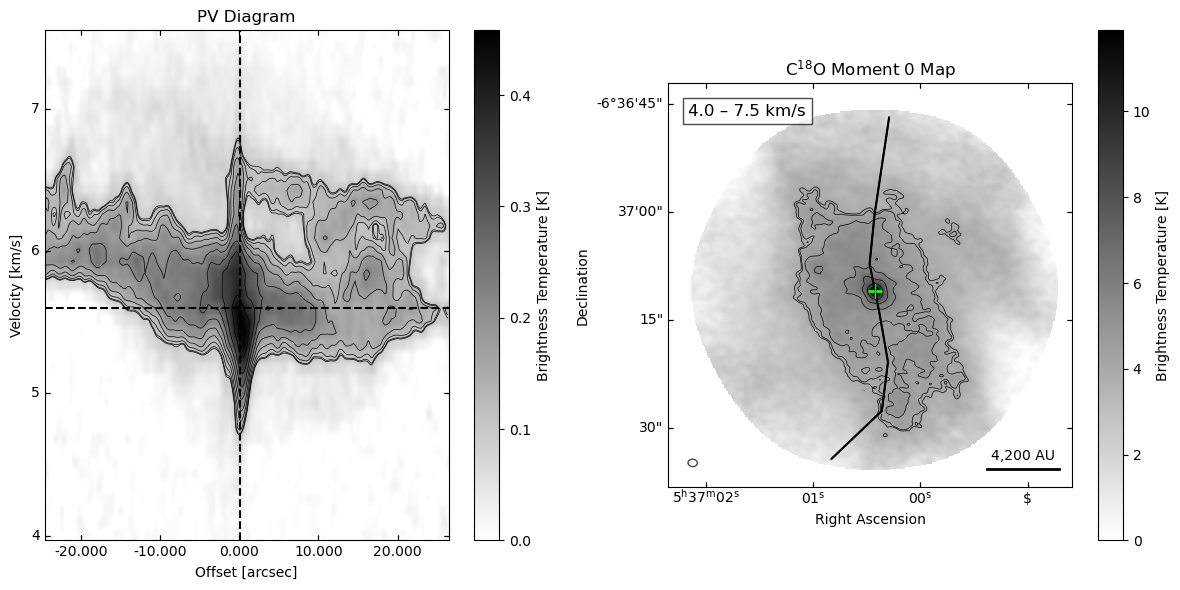

In [46]:
fig = plt.figure(figsize=(12, 6))

# === PV Diagram (ax1) ===
ax1 = fig.add_subplot(1, 2, 1, projection=ww)
im1 = ax1.imshow(C18O_pvdiagram.data, aspect='auto', cmap='binary', vmin=0, origin='lower')

ax0 = ax1.coords[0]
ax0.set_format_unit(u.arcsec, decimal=True, show_decimal_unit=True)
ax00 = ax1.coords[1]
ax00.set_format_unit(u.km/u.s, decimal=True, show_decimal_unit=True)

ax1.set_xlabel('Offset [arcsec]')
ax1.set_ylabel('Velocity [km/s]')
ax1.set_title('PV Diagram')
ax1.tick_params(axis='both', direction='in', which='both')

cb1 = plt.colorbar(im1, ax=ax1)
cb1.set_label('Brightness Temperature [K]')

plot_contours(C18O_pvdiagram.data, 'black', 0.1, 0.4, 9, ax=ax1)

# === Moment 0 Map (ax2) ===
ax2 = fig.add_subplot(1, 2, 2, projection=cube_12CO_pvdiagram.wcs.celestial)
im2 = ax2.imshow(data_C18O, origin='lower', cmap='binary', vmin=0)
ax2.tick_params(axis='both', direction='in', which='both')

# Add guide lines
ax1.axvline(x=x0_pix, color='black', linestyle='--', label='0″ Offset')
ax1.axhline(y=y56_pix, color='black', linestyle='--', label='5.6 km/s')

# Colorbar
cb2 = plt.colorbar(im2, ax=ax2)
cb2.set_label('Brightness Temperature [K]')

# Plot contours on ax2
plot_contours(data_C18O, color='black', min_level=4, max_level=15, number_of_levels=9, ax=ax2)

# Labels
ax2.set_xlabel('Right Ascension')
ax2.set_ylabel('Declination')
ax2.set_title(r'C$^{18}$O Moment 0 Map')

# Add velocity label
ax2.text(0.05, 0.95, f"{v_min_C18O:.1f} – {v_max_C18O:.1f} km/s", transform=ax2.transAxes, fontsize=12,
         verticalalignment='top', bbox=dict(facecolor='white', alpha=0.7))

# Add beam
beam_C18O = beam(1.30/0.17, 1.03/0.17, 85.77, 80, 80) #beam arcseconds times pixel arcseconds for the fits file
ax2.add_patch(beam_C18O)

# Set limits (adjust as needed based on real image size)
ax2.set_xlim(60, 390) 
ax2.set_ylim(60, 390)

# Scale bar setup
scale_bar_length_pix = 10 / 0.17  # pixels for 10 arcsec
x_start = ax2.get_xlim()[0] + 260  
y_start = ax2.get_ylim()[0] + 15

ax2.plot([x_start, x_start + scale_bar_length_pix], [y_start, y_start], color='black', linewidth=2)
ax2.text(x_start + scale_bar_length_pix / 2, y_start + 5, "4,200 AU", color='black', ha='center', va='bottom', fontsize=10)

# Path overlay
path_most_emission.show_on_axis(ax2, spacing=1, color='black')

# Plot marker
ax2.plot(229, 220, marker='+', color='lime', markersize=10, label='Marker')

plt.tight_layout()
plt.show()

# 12CO

In [86]:
# Chose channels with emission
v_min_12CO = 4.0
v_max_12CO = 7.5
slab_12CO = cube_12CO.spectral_slab(v_min_12CO*u.km/u.s, v_max_12CO*u.km/u.s)
slab_12CO_pvdiagram = cube_12CO_pvdiagram.spectral_slab(v_min_12CO*u.km/u.s, v_max_12CO*u.km/u.s)
# Create moment 0 map
moment0 = slab_12CO.moment(order=0)
data_12CO = moment0.hdu.data

slab_12CO_blue = cube_12CO.spectral_slab(0*u.km/u.s, 4.2*u.km/u.s)
moment0 = slab_12CO_blue.moment(order=0)
data_12CO_blue = moment0.hdu.data  # assuming 2D

slab_12CO_red = cube_12CO.spectral_slab(7.2*u.km/u.s, 11.6*u.km/u.s)
moment0 = slab_12CO_red.moment(order=0)
data_12CO_red = moment0.hdu.data  # assuming 2D

Setting the 'color' property will override the edgecolor or facecolor properties.


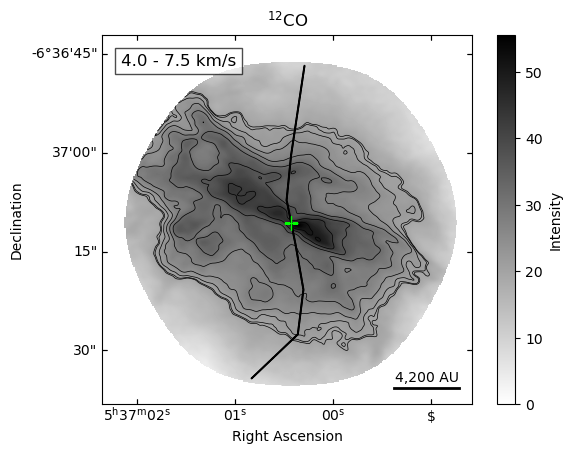

In [50]:
fig = plt.figure()
ax = pl.plt.subplot(111, projection=cube_12CO.wcs.celestial)
im = ax.imshow(data_12CO, origin='lower', cmap='binary', vmin=0)

# Plot contours
plot_contours(data_12CO, color='black', min_level=20, max_level=50, number_of_levels=9, ax=ax)

# Plot the protostar marker
ax.plot(x_marker, y_marker, marker='+', color='lime', markersize=10, label='Marker')

# Add labels
ax.set_xlabel('Right Ascension')
ax.set_ylabel('Declination')
ax.set_title(r'$^{12}$CO')

# Add velocity label in the top left of the subplot
ax.text(0.05, 0.95, f"{v_min_12CO:.1f} - {v_max_12CO:.1f} km/s", transform=ax.transAxes, fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.7))

# Move ticks inside
ax.tick_params(axis='both', direction='in', which='both')

# Add colorbar
plt.colorbar(im, ax=ax, label='Intensity')

# Add beam
beam_12CO = beam(1.25/0.17, 0.98/0.17, 84.20, 80, 80) #beam arcseconds times pixel arcseconds for the fits file
ax2.add_patch(beam_12CO)

# Set offset limits
ax.set_xlim(60, 390) 
ax.set_ylim(60, 390)

# Set starting point for the scale bar (in arcseconds)
x_start = ax.get_xlim()[0] + 260
y_start = ax.get_ylim()[0] + 15

# Length of the bar in arcseconds
scale_bar_length = 10/0.17 # pixels (10 arcseconds in the image)

# Plot the scale bar
ax.plot([x_start, x_start + scale_bar_length], [y_start, y_start], color='black', linewidth=2)

# Label it
ax.text(x_start + scale_bar_length / 2, y_start + 3, "4,200 AU",
        color='black', ha='center', va='bottom', fontsize=10)

path_most_emission.show_on_axis(ax, spacing=1, color='black')

# Save image
# plt.savefig("HOPS164_12CO_contour_map_with_pvdiagram_path.png", format="png", dpi=300, bbox_inches="tight")

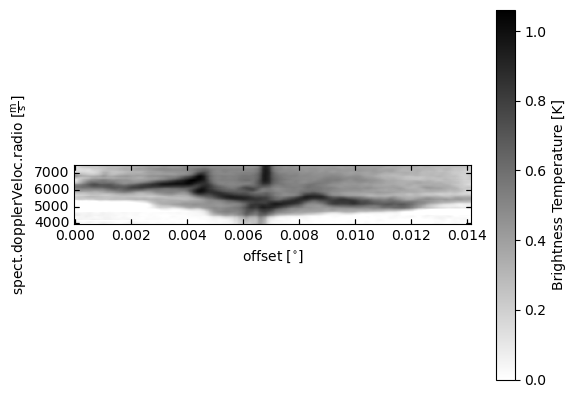

In [51]:
CO_pvdiagram = extract_pv_slice(slab_12CO_pvdiagram, path_most_emission, spacing=1) 

ax=pl.plt.axes(111,projection=wcs.WCS(CO_pvdiagram.header))
im=ax.imshow(CO_pvdiagram.data, cmap='binary', vmin=0)
cb=pl.colorbar(mappable=im)
cb.set_label('Brightness Temperature [K]')

# Move ticks inside
ax.tick_params(axis='both', direction='in', which='both')

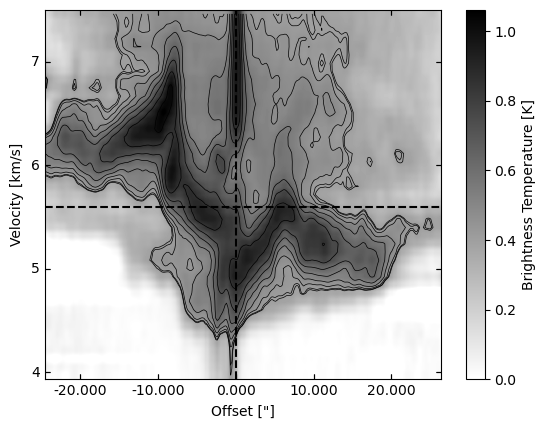

In [52]:
# Get the data array from the PV diagram
data = CO_pvdiagram.data
ny, nx = data.shape

# Define offset and velocity axes
x_axis = np.arange(data.shape[1])  # Offset in pixels
y_axis = np.linspace(v_min_12CO, v_max_12CO, data.shape[0])  # Velocity in km/s

# Center of the offset axis (pixel 145 = 0 arcsec)
center_index = 144 # center of pvdiagram

# Update WCS header to match that center
pv_header_centered = CO_pvdiagram.header.copy()
pv_header_centered['CRPIX1'] = center_index + 1  # 1-based FITS indexing
pv_header_centered['CRVAL1'] = 0.0  # Center at 0 arcsec

ww = wcs.WCS(pv_header_centered)

# Plot
ax = pl.plt.axes(111, projection=ww)
im = ax.imshow(CO_pvdiagram.data, aspect='auto', cmap='binary', vmin=0)
cb = pl.colorbar(mappable=im)
cb.set_label('Brightness Temperature [K]')

ax0 = ax.coords[0]
ax0.set_format_unit(u.arcsec, decimal=True, show_decimal_unit=True)
ax1 = ax.coords[1]
ax1.set_format_unit(u.km/u.s, decimal=True, show_decimal_unit=True)

ax.set_ylabel('Velocity [km/s]')
ax.set_xlabel('Offset ["]')
ax.tick_params(axis='both', direction='in', which='both')

plot_contours(CO_pvdiagram.data, 'black', 0.4, 1.0, 9, ax=ax)

# Add guide lines
x0_pix = nx / 2 - 5.5
ax.axvline(x=x0_pix, color='black', linestyle='--', label='0″ Offset')

velocity_mps = 5.6 * 1000 # kilometers
x_center = nx // 2
y56_pix = ww.wcs_world2pix([[ww.wcs_pix2world([[x_center, 0]], 0)[0][0], velocity_mps]], 0)[0][1]
ax.axhline(y=y56_pix, color='black', linestyle='--', label='5.6 km/s')

Setting the 'color' property will override the edgecolor or facecolor properties.


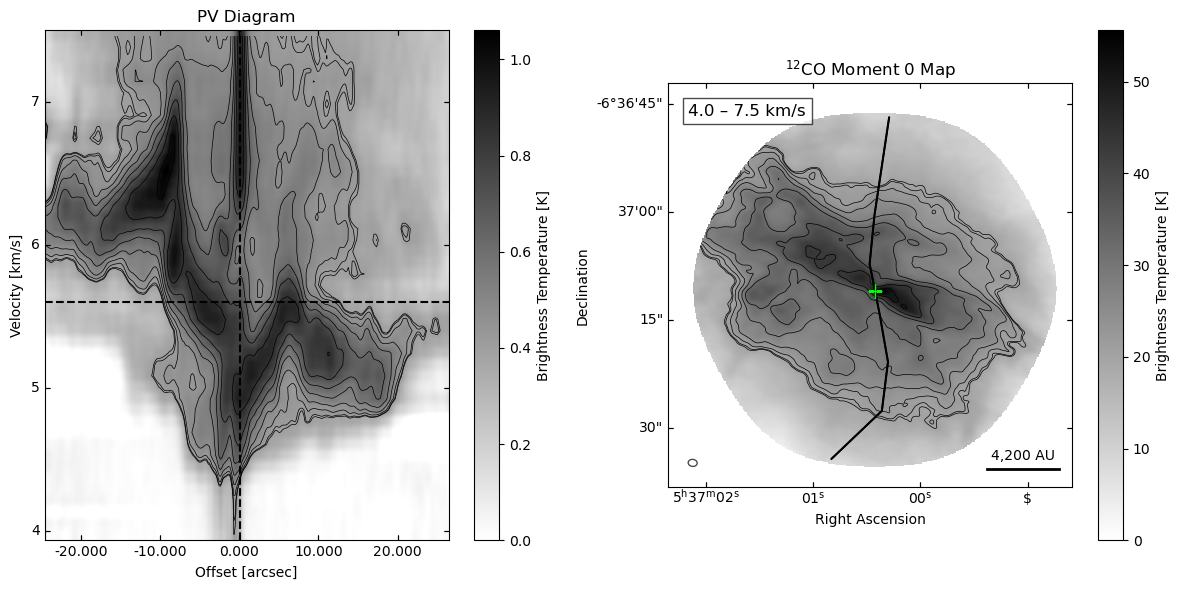

In [54]:
fig = plt.figure(figsize=(12, 6))

# === PV Diagram (ax1) ===
ax1 = fig.add_subplot(1, 2, 1, projection=ww)
im1 = ax1.imshow(CO_pvdiagram.data, aspect='auto', cmap='binary', vmin=0, origin='lower')

ax0 = ax1.coords[0]
ax0.set_format_unit(u.arcsec, decimal=True, show_decimal_unit=True)
ax00 = ax1.coords[1]
ax00.set_format_unit(u.km/u.s, decimal=True, show_decimal_unit=True)

ax1.set_xlabel('Offset [arcsec]')
ax1.set_ylabel('Velocity [km/s]')
ax1.set_title('PV Diagram')
ax1.tick_params(axis='both', direction='in', which='both')

cb1 = plt.colorbar(im1, ax=ax1)
cb1.set_label('Brightness Temperature [K]')

plot_contours(CO_pvdiagram.data, 'black', 0.4, 1.0, 9, ax=ax1)

# === Moment 0 Map (ax2) ===
ax2 = fig.add_subplot(1, 2, 2, projection=cube_12CO_pvdiagram.wcs.celestial)
im2 = ax2.imshow(data_12CO, origin='lower', cmap='binary', vmin=0)
ax2.tick_params(axis='both', direction='in', which='both')

# Add guide lines
ax1.axvline(x=x0_pix, color='black', linestyle='--', label='0″ Offset')
ax1.axhline(y=y56_pix, color='black', linestyle='--', label='5.6 km/s')

# Colorbar
cb2 = plt.colorbar(im2, ax=ax2)
cb2.set_label('Brightness Temperature [K]')

# Plot contours on ax2
plot_contours(data_12CO, color='black', min_level=20, max_level=50, number_of_levels=9, ax=ax2)

# Labels
ax2.set_xlabel('Right Ascension')
ax2.set_ylabel('Declination')
ax2.set_title(r'$^{12}$CO Moment 0 Map')

# Add velocity label
ax2.text(0.05, 0.95, f"{v_min_12CO:.1f} – {v_max_12CO:.1f} km/s", transform=ax2.transAxes, fontsize=12,
         verticalalignment='top', bbox=dict(facecolor='white', alpha=0.7))

# Add beam
beam_12CO = beam(1.25/0.17, 0.98/0.17, 84.20, 80, 80) #beam arcseconds times pixel arcseconds for the fits file
ax2.add_patch(beam_12CO)

# Set limits (adjust as needed based on real image size)
ax2.set_xlim(60, 390) 
ax2.set_ylim(60, 390)

# Scale bar setup
scale_bar_length_pix = 10 / 0.17  # pixels for 10 arcsec
x_start = ax2.get_xlim()[0] + 260  
y_start = ax2.get_ylim()[0] + 15

ax2.plot([x_start, x_start + scale_bar_length_pix], [y_start, y_start], color='black', linewidth=2)
ax2.text(x_start + scale_bar_length_pix / 2, y_start + 5, "4,200 AU", color='black', ha='center', va='bottom', fontsize=10)

# Path overlay
path_most_emission.show_on_axis(ax2, spacing=1, color='black')

# Plot marker
ax2.plot(229, 220, marker='+', color='lime', markersize=10, label='Marker')

plt.tight_layout()
plt.show()

# 13CO

In [55]:
# Chose channels with emission
v_min_13CO = 4.0
v_max_13CO = 7.5
slab_13CO = cube_13CO.spectral_slab(v_min_13CO*u.km/u.s, v_max_13CO*u.km/u.s)
slab_13CO_pvdiagram = cube_13CO_pvdiagram.spectral_slab(v_min_13CO*u.km/u.s, v_max_13CO*u.km/u.s)

# Create moment 0 map
moment0 = slab_13CO.moment(order=0)

# Access moment 0 data
data_13CO = moment0.hdu.data

Setting the 'color' property will override the edgecolor or facecolor properties.


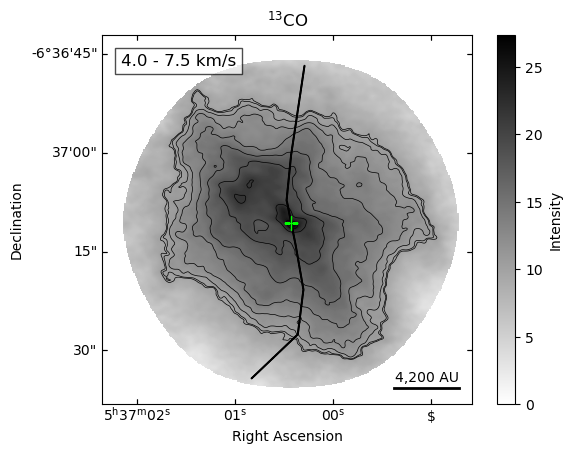

In [57]:
fig = plt.figure()
ax = pl.plt.subplot(111, projection=cube_13CO.wcs.celestial)
im = ax.imshow(data_13CO, origin='lower', cmap='binary', vmin=0)

# Plot contours
plot_contours(data_13CO, color='black', min_level=10, max_level=25, number_of_levels=9, ax=ax)

# Plot the protostar marker
ax.plot(x_marker, y_marker, marker='+', color='lime', markersize=10, label='Marker')

# Add labels
ax.set_xlabel('Right Ascension')
ax.set_ylabel('Declination')
ax.set_title(r'$^{13}$CO')

# Add velocity label in the top left of the subplot
ax.text(0.05, 0.95, f"{v_min_13CO:.1f} - {v_max_13CO:.1f} km/s", transform=ax.transAxes, fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.7))

# Move ticks inside
ax.tick_params(axis='both', direction='in', which='both')

# Add colorbar
plt.colorbar(im, ax=ax, label='Intensity')

# Add beam
beam_13CO = beam(1.29/0.17, 1.03/0.17, 84.42, 80, 80) #beam arcseconds times pixel arcseconds for the fits file
ax2.add_patch(beam_13CO)

# Set offset limits
ax.set_xlim(60, 390) 
ax.set_ylim(60, 390)

# Set starting point for the scale bar (in arcseconds)
x_start = ax.get_xlim()[0] + 260
y_start = ax.get_ylim()[0] + 15

# Length of the bar in arcseconds
scale_bar_length = 10/0.17 # pixels (10 arcseconds in the image)

# Plot the scale bar
ax.plot([x_start, x_start + scale_bar_length], [y_start, y_start], color='black', linewidth=2)

# Label it
ax.text(x_start + scale_bar_length / 2, y_start + 3, "4,200 AU",
        color='black', ha='center', va='bottom', fontsize=10)

path_most_emission.show_on_axis(ax, spacing=1, color='black')

# Save image
# plt.savefig("HOPS164_13CO_contour_map_with_pvdiagram_path.png", format="png", dpi=300, bbox_inches="tight")

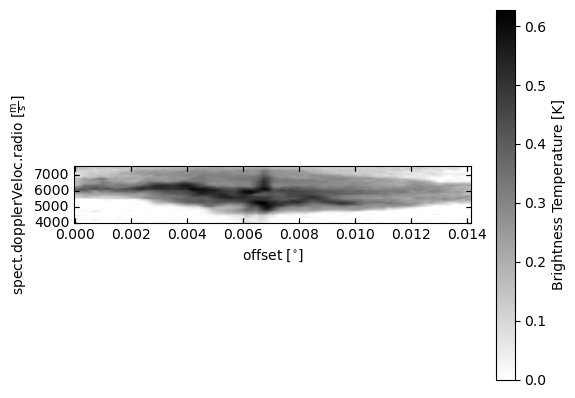

In [58]:
s13CO_pvdiagram = extract_pv_slice(slab_13CO_pvdiagram, path_most_emission, spacing=1) 

ax=pl.plt.axes(111,projection=wcs.WCS(s13CO_pvdiagram.header))
im=ax.imshow(s13CO_pvdiagram.data, cmap='binary', vmin=0)
cb=pl.colorbar(mappable=im)
cb.set_label('Brightness Temperature [K]')

# Move ticks inside
ax.tick_params(axis='both', direction='in', which='both')

300 43


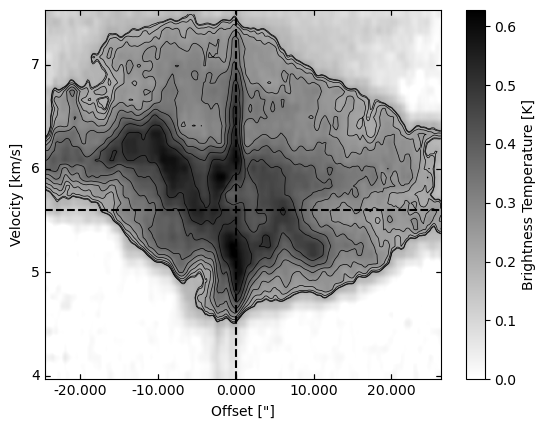

In [59]:
# Get the data array from the PV diagram
data = s13CO_pvdiagram.data
ny, nx = data.shape
print(nx, ny)

# Define offset and velocity axes
x_axis = np.arange(data.shape[1])  # Offset in pixels
y_axis = np.linspace(v_min_13CO, v_max_13CO, data.shape[0])  # Velocity in km/s

# Center of the offset axis (pixel 145 = 0 arcsec)
center_index = 144 # center of pvdiagram

# Update WCS header to match that center
pv_header_centered = s13CO_pvdiagram.header.copy()
pv_header_centered['CRPIX1'] = center_index + 1  # 1-based FITS indexing
pv_header_centered['CRVAL1'] = 0.0  # Center at 0 arcsec

ww = wcs.WCS(pv_header_centered)

# Plot
ax = pl.plt.axes(111, projection=ww)
im = ax.imshow(s13CO_pvdiagram.data, aspect='auto', cmap='binary', vmin=0)
cb = pl.colorbar(mappable=im)
cb.set_label('Brightness Temperature [K]')

ax0 = ax.coords[0]
ax0.set_format_unit(u.arcsec, decimal=True, show_decimal_unit=True)
ax1 = ax.coords[1]
ax1.set_format_unit(u.km/u.s, decimal=True, show_decimal_unit=True)

ax.set_ylabel('Velocity [km/s]')
ax.set_xlabel('Offset ["]')
ax.tick_params(axis='both', direction='in', which='both')

plot_contours(s13CO_pvdiagram.data, 'black', 0.2, 0.5, 9, ax=ax)

# Add guide lines
x0_pix = nx / 2 - 5.5
ax.axvline(x=x0_pix, color='black', linestyle='--', label='0″ Offset')

velocity_mps = 5.6 * 1000 # kilometers
x_center = nx // 2
y56_pix = ww.wcs_world2pix([[ww.wcs_pix2world([[x_center, 0]], 0)[0][0], velocity_mps]], 0)[0][1]
ax.axhline(y=y56_pix, color='black', linestyle='--', label='5.6 km/s')

Setting the 'color' property will override the edgecolor or facecolor properties.


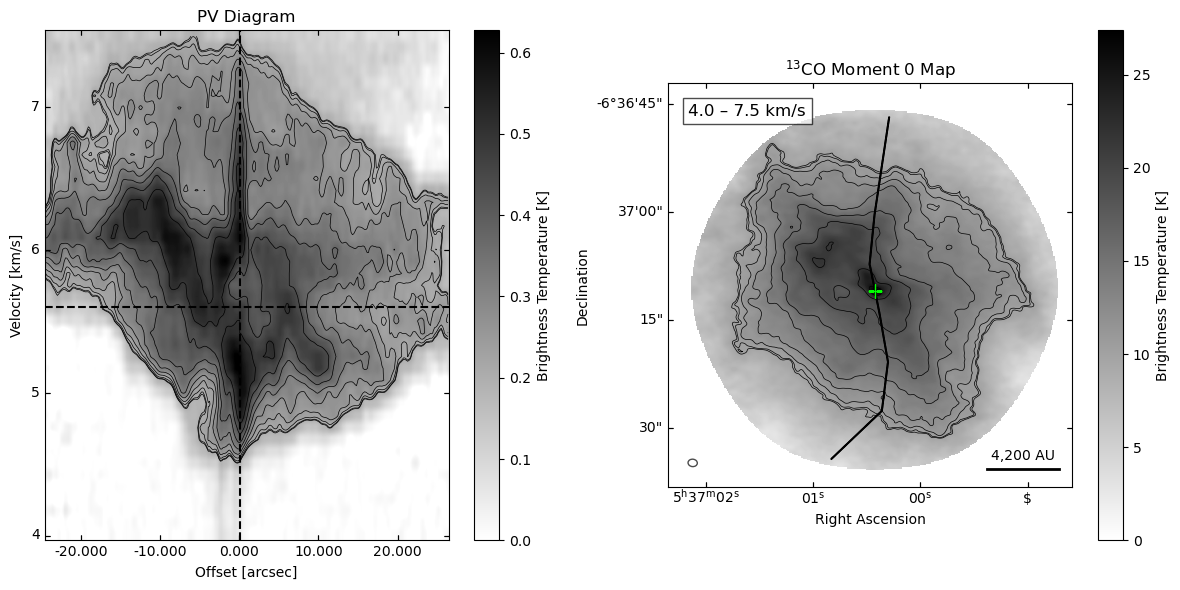

In [61]:
fig = plt.figure(figsize=(12, 6))

# === PV Diagram (ax1) ===
ax1 = fig.add_subplot(1, 2, 1, projection=ww)
im1 = ax1.imshow(s13CO_pvdiagram.data, aspect='auto', cmap='binary', vmin=0, origin='lower')

ax0 = ax1.coords[0]
ax0.set_format_unit(u.arcsec, decimal=True, show_decimal_unit=True)
ax00 = ax1.coords[1]
ax00.set_format_unit(u.km/u.s, decimal=True, show_decimal_unit=True)

ax1.set_xlabel('Offset [arcsec]')
ax1.set_ylabel('Velocity [km/s]')
ax1.set_title('PV Diagram')
ax1.tick_params(axis='both', direction='in', which='both')

cb1 = plt.colorbar(im1, ax=ax1)
cb1.set_label('Brightness Temperature [K]')

plot_contours(s13CO_pvdiagram.data, 'black', 0.2, 0.5, 9, ax=ax1)

# Add guide lines
ax1.axvline(x=x0_pix, color='black', linestyle='--', label='0″ Offset')
ax1.axhline(y=y56_pix, color='black', linestyle='--', label='5.6 km/s')

# === Moment 0 Map (ax2) ===
ax2 = fig.add_subplot(1, 2, 2, projection=cube_12CO_pvdiagram.wcs.celestial)
im2 = ax2.imshow(data_13CO, origin='lower', cmap='binary', vmin=0)
ax2.tick_params(axis='both', direction='in', which='both')

# Colorbar
cb2 = plt.colorbar(im2, ax=ax2)
cb2.set_label('Brightness Temperature [K]')

# Plot contours on ax2
plot_contours(data_13CO, color='black', min_level=10, max_level=25, number_of_levels=9, ax=ax2)

# Labels
ax2.set_xlabel('Right Ascension')
ax2.set_ylabel('Declination')
ax2.set_title(r'$^{13}$CO Moment 0 Map')

# Add velocity label
ax2.text(0.05, 0.95, f"{v_min_12CO:.1f} – {v_max_12CO:.1f} km/s", transform=ax2.transAxes, fontsize=12,
         verticalalignment='top', bbox=dict(facecolor='white', alpha=0.7))

# Add beam
beam_13CO = beam(1.29/0.17, 1.03/0.17, 84.42, 80, 80) #beam arcseconds times pixel arcseconds for the fits file
ax2.add_patch(beam_13CO)

# Set limits (adjust as needed based on real image size)
ax2.set_xlim(60, 390) 
ax2.set_ylim(60, 390)

# Scale bar setup
scale_bar_length_pix = 10 / 0.17  # pixels for 10 arcsec
x_start = ax2.get_xlim()[0] + 260  
y_start = ax2.get_ylim()[0] + 15

ax2.plot([x_start, x_start + scale_bar_length_pix], [y_start, y_start], color='black', linewidth=2)
ax2.text(x_start + scale_bar_length_pix / 2, y_start + 5, "4,200 AU", color='black', ha='center', va='bottom', fontsize=10)

# Path overlay
path_most_emission.show_on_axis(ax2, spacing=1, color='black')

# Plot marker
ax2.plot(229, 220, marker='+', color='lime', markersize=10, label='Marker')

plt.tight_layout()
plt.show()

# All PVdiagrams together

In [62]:
# Helper function
def add_panel_label(ax, label, x=0.02, y=0.95):
    ax.text(x, y, f'({label})', transform=ax.transAxes,
            fontsize=12, fontweight='bold', va='top', ha='left')


Setting the 'color' property will override the edgecolor or facecolor properties.


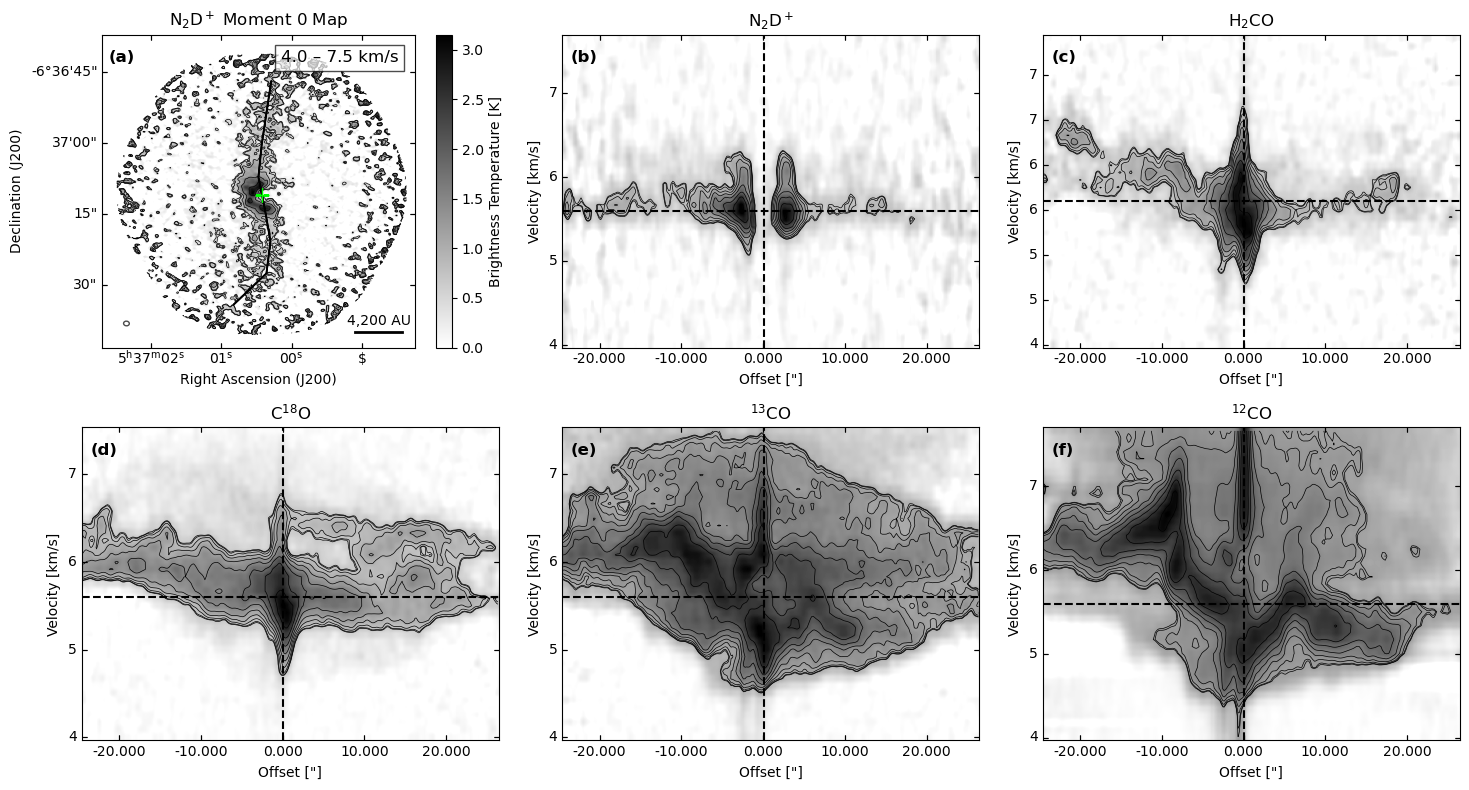

In [88]:
fig = plt.figure(figsize=(15, 8))

ax0 = fig.add_subplot(2, 3, 1, projection=cube_N2Dp_pvdiagram.wcs.celestial)
ax1 = fig.add_subplot(2, 3, 2, projection=ww)
ax2 = fig.add_subplot(2, 3, 3, projection=ww)
ax3 = fig.add_subplot(2, 3, 4, projection=ww)
ax4 = fig.add_subplot(2, 3, 5, projection=ww)
ax5 = fig.add_subplot(2, 3, 6, projection=ww)

add_panel_label(ax0, 'a')
add_panel_label(ax1, 'b')
add_panel_label(ax2, 'c')
add_panel_label(ax3, 'd')
add_panel_label(ax4, 'e')
add_panel_label(ax5, 'f')

# === Moment 0 Map (ax2) ===
im0 = ax0.imshow(data_N2Dp, origin='lower', cmap='binary', vmin=0)
ax0.tick_params(axis='both', direction='in', which='both')

# Colorbar
cb0 = plt.colorbar(im0, ax=ax0)
cb0.set_label('Brightness Temperature [K]')

# Plot contours on ax0
plot_contours(data_N2Dp, color='black', min_level=0.4, max_level=2.5, number_of_levels=5, ax=ax0)

# Labels
ax0.set_xlabel('Right Ascension (J200)')
ax0.set_ylabel('Declination (J200)')
ax0.set_title(r'N$_2$D$^+$ Moment 0 Map')

# Add velocity label
ax0.text(0.57, 0.95, f"{v_min_N2Dp:.1f} – {v_max_N2Dp:.1f} km/s", transform=ax0.transAxes, fontsize=12,
         verticalalignment='top', bbox=dict(facecolor='white', alpha=0.7))

# Add beam
beam_N2Dp = beam(1.22/0.17, 0.98/0.17, 84.98, 60, 60)  # use actual beam if available
ax0.add_patch(beam_N2Dp)

# Set limits (adjust as needed based on real image size)
ax0.set_xlim(30, 420) 
ax0.set_ylim(30, 420)

# Scale bar setup
scale_bar_length_pix = 10 / 0.17  # pixels for 10 arcsec
x_start = ax0.get_xlim()[0] + 315   
y_start = ax0.get_ylim()[0] + 20  

ax0.plot([x_start, x_start + scale_bar_length_pix], [y_start, y_start], color='black', linewidth=2)
ax0.text(x_start + scale_bar_length_pix / 2, y_start + 5, "4,200 AU", color='black', ha='center', va='bottom', fontsize=10)

# Path overlay
path_most_emission.show_on_axis(ax0, spacing=1, color='black')

# Plot marker
ax0.plot(229, 220, marker='+', color='lime', markersize=10, label='Marker')



# === PV Diagram (ax_N2Dp) ===
im1 = ax1.imshow(N2Dp_pvdiagram.data, aspect='auto', cmap='binary', vmin=0, origin='lower')

ax10 = ax1.coords[0]
ax10.set_format_unit(u.arcsec, decimal=True, show_decimal_unit=True)
ax100 = ax1.coords[1]
ax100.set_format_unit(u.km/u.s, decimal=True, show_decimal_unit=True)

ax1.set_xlabel('Offset ["]')
ax1.set_ylabel('Velocity [km/s]')
ax1.set_title(r'N$_2$D$^+$')
ax1.tick_params(axis='both', direction='in', which='both')

# cb1 = plt.colorbar(im1, ax=ax1)
# cb1.set_label('Brightness Temperature [K]')

plot_contours(N2Dp_pvdiagram.data, 'black', 0.05, 0.2, 9, ax1)

# Add guide lines
ax1.axvline(x=x0_pix, color='black', linestyle='--', label='0″ Offset')
ax1.axhline(y=y56_pix, color='black', linestyle='--', label='5.6 km/s')



# === PV Diagram (ax2) ===
im2 = ax2.imshow(H2CO_pvdiagram.data, aspect='auto', cmap='binary', vmin=0, origin='lower')

ax20 = ax2.coords[0]
ax20.set_format_unit(u.arcsec, decimal=True, show_decimal_unit=True)
ax200 = ax2.coords[1]
ax200.set_format_unit(u.km/u.s, decimal=True, show_decimal_unit=True)

ax2.set_xlabel('Offset ["]')
ax2.set_ylabel('Velocity [km/s]')
ax2.set_title(r'H$_2$CO')
ax2.tick_params(axis='both', direction='in', which='both')

# cb2 = plt.colorbar(im2, ax=ax2)
# cb2.set_label('Brightness Temperature [K]')

plot_contours(H2CO_pvdiagram.data, 'black', 0.05, 0.2, 9, ax2)

# Add guide lines
ax2.axvline(x=x0_pix, color='black', linestyle='--', label='0″ Offset')
ax2.axhline(y=y56_pix, color='black', linestyle='--', label='5.6 km/s')



# === PV Diagram (ax3) ===
im3 = ax3.imshow(C18O_pvdiagram.data, aspect='auto', cmap='binary', vmin=0, origin='lower')

ax30 = ax3.coords[0]
ax30.set_format_unit(u.arcsec, decimal=True, show_decimal_unit=True)
ax300 = ax3.coords[1]
ax300.set_format_unit(u.km/u.s, decimal=True, show_decimal_unit=True)

ax3.set_xlabel('Offset ["]')
ax3.set_ylabel('Velocity [km/s]')
ax3.set_title(r'C$^{18}$O')
ax3.tick_params(axis='both', direction='in', which='both')

# cb3 = plt.colorbar(im1, ax=ax3)
# cb3.set_label('Brightness Temperature [K]')

plot_contours(C18O_pvdiagram.data, 'black', 0.1, 0.4, 9, ax=ax3)

# Add guide lines
ax3.axvline(x=x0_pix, color='black', linestyle='--', label='0″ Offset')
ax3.axhline(y=y56_pix, color='black', linestyle='--', label='5.6 km/s')



# === PV Diagram (ax4) ===
im4 = ax4.imshow(s13CO_pvdiagram.data, aspect='auto', cmap='binary', vmin=0, origin='lower')

ax40 = ax4.coords[0]
ax40.set_format_unit(u.arcsec, decimal=True, show_decimal_unit=True)
ax400 = ax4.coords[1]
ax400.set_format_unit(u.km/u.s, decimal=True, show_decimal_unit=True)

ax4.set_xlabel('Offset ["]')
ax4.set_ylabel('Velocity [km/s]')
ax4.set_title(r'$^{13}$CO')
ax4.tick_params(axis='both', direction='in', which='both')

# cb4 = plt.colorbar(im1, ax=ax4)
# cb4.set_label('Brightness Temperature [K]')

plot_contours(s13CO_pvdiagram.data, 'black', 0.2, 0.5, 9, ax=ax4)

# Add guide lines
ax4.axvline(x=x0_pix, color='black', linestyle='--', label='0″ Offset')
ax4.axhline(y=y56_pix, color='black', linestyle='--', label='5.6 km/s')



# === PV Diagram (ax5) ===
im5 = ax5.imshow(CO_pvdiagram.data, aspect='auto', cmap='binary', vmin=0, origin='lower')

ax50 = ax5.coords[0]
ax50.set_format_unit(u.arcsec, decimal=True, show_decimal_unit=True)
ax500 = ax5.coords[1]
ax500.set_format_unit(u.km/u.s, decimal=True, show_decimal_unit=True)

ax5.set_xlabel('Offset ["]')
ax5.set_ylabel('Velocity [km/s]')
ax5.set_title(r'$^{12}$CO')
ax5.tick_params(axis='both', direction='in', which='both')

# cb5 = plt.colorbar(im5, ax=ax5)
# cb5.set_label('Brightness Temperature [K]')

plot_contours(CO_pvdiagram.data, 'black', 0.4, 1.0, 9, ax=ax5)

# Add guide lines
ax5.axvline(x=x0_pix, color='black', linestyle='--', label='0″ Offset')
ax5.axhline(y=y56_pix, color='black', linestyle='--', label='5.6 km/s')

plt.tight_layout()

# plt.savefig("HOPS164_all_most_emission_pvdiagrams.pdf", format="pdf", dpi=300, bbox_inches="tight")

# All Contour Maps

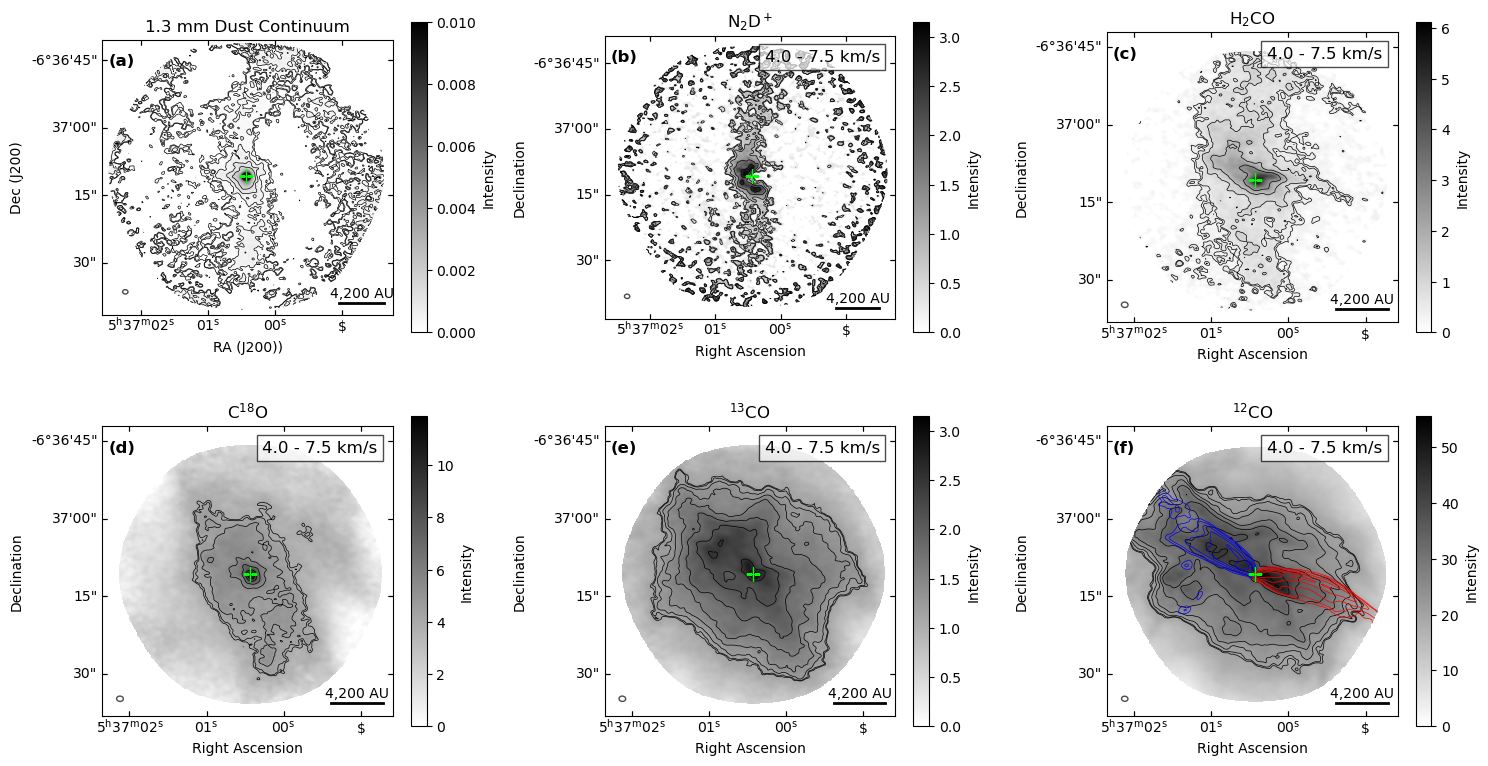

In [ ]:
fig = plt.figure(figsize=(15, 8))

ax0 = fig.add_subplot(2, 3, 1, projection=cube_N2Dp.wcs.celestial)
ax1 = fig.add_subplot(2, 3, 2, projection=cube_N2Dp.wcs.celestial)
ax2 = fig.add_subplot(2, 3, 3, projection=cube_H2CO.wcs.celestial)
ax3 = fig.add_subplot(2, 3, 4, projection=cube_C18O.wcs.celestial)
ax4 = fig.add_subplot(2, 3, 5, projection=cube_13CO.wcs.celestial)
ax5 = fig.add_subplot(2, 3, 6, projection=cube_12CO.wcs.celestial)

add_panel_label(ax0, 'a')
add_panel_label(ax1, 'b')
add_panel_label(ax2, 'c')
add_panel_label(ax3, 'd')
add_panel_label(ax4, 'e')
add_panel_label(ax5, 'f')



im0 = ax0.imshow(hdu.data, origin='lower', cmap='binary', vmin=0, vmax=0.01)

# Plot contours
plot_contours(hdu.data, 'black', 0, 0.0015, 5, ax=ax0)

# Add beam
beam_continuum = beam(1.20/0.17, 0.97/0.17, 85.18, 70, 70)
ax0.add_patch(beam_continuum)

# Set pixel limits
ax0.set_xlim(40, 420)  
ax0.set_ylim(40, 400)

# Set starting point for the scale bar (in pixels)
x_start = ax0.get_xlim()[0] + 310
y_start = ax0.get_ylim()[0] + 15

# Length of the bar in amount of arcseconds (divide by arcseconds per pixel)
scale_bar_length = 10/0.17  # pixels

# Plot the scale bar
ax0.plot([x_start, x_start + scale_bar_length], [y_start, y_start], color='black', linewidth=2)

# Label it
ax0.text(x_start + scale_bar_length / 2, y_start + 3, "4,200 AU",
        color='black', ha='center', va='bottom', fontsize=10)

# Plot the protostar marker
ax0.plot(x_marker, y_marker, marker='+', color='lime', markersize=10, label='Marker')

# Move ticks inside
ax0.tick_params(axis='both', direction='in', which='both')

# Add colorbar
plt.colorbar(im, ax=ax0, label='Intensity')

# Set labels
ax0.set_xlabel('RA (J200))')
ax0.set_ylabel('Dec (J200)')
ax0.set_title('1.3 mm Dust Continuum')







im1 = ax1.imshow(data_N2Dp, origin='lower', cmap='binary', vmin=0)

# Plot contours
plot_contours(data_N2Dp, color='black', min_level=0.4, max_level=2.5, number_of_levels=5, ax=ax1)

# Plot the protostar marker
ax1.plot(x_marker, y_marker, marker='+', color='lime', markersize=10, label='Marker')

# Add labels
ax1.set_xlabel('Right Ascension')
ax1.set_ylabel('Declination')
ax1.set_title(r'N$_2$D$^+$')

# Add velocity label in the top left of the subplot
ax1.text(0.55, 0.95, f"{v_min_N2Dp:.1f} - {v_max_N2Dp:.1f} km/s", transform=ax1.transAxes, fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.7))

# Move ticks inside
ax1.tick_params(axis='both', direction='in', which='both')

# Add colorbar
plt.colorbar(im1, ax=ax1, label='Intensity')

# Add beam
beam_N2Dp = beam(1.22/0.17, 0.98/0.17, 84.98, 60, 60)  # use actual beam if available
ax1.add_patch(beam_N2Dp)

# Set offset limits
ax1.set_xlim(30, 420) 
ax1.set_ylim(30, 410)

# Set starting point for the scale bar (in arcseconds)
x_start = ax1.get_xlim()[0] + 310
y_start = ax1.get_ylim()[0] + 15

# Length of the bar in arcseconds
scale_bar_length = 10/0.17 # pixels (10 arcseconds in the image)

# Plot the scale bar
ax1.plot([x_start, x_start + scale_bar_length], [y_start, y_start], color='black', linewidth=2)

# Label it
ax1.text(x_start + scale_bar_length / 2, y_start + 3, "4,200 AU",
        color='black', ha='center', va='bottom', fontsize=10)




im2 = ax2.imshow(data_H2CO, origin='lower', cmap='binary', vmin=0)

# Plot contours
plot_contours(data_H2CO, color='black', min_level=0.4, max_level=2.5, number_of_levels=5, ax=ax2)

# Plot the protostar marker
ax2.plot(x_marker, y_marker, marker='+', color='lime', markersize=10, label='Marker')

# Add labels
ax2.set_xlabel('Right Ascension')
ax2.set_ylabel('Declination')
ax2.set_title(r'H$_2$CO')

# Add velocity label in the top left of the subplot
ax2.text(0.55, 0.95, f"{v_min_H2CO:.1f} - {v_max_H2CO:.1f} km/s", transform=ax2.transAxes, fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.7))

# Move ticks inside
ax2.tick_params(axis='both', direction='in', which='both')

# Add colorbar
plt.colorbar(im2, ax=ax2, label='Intensity')

# Add beam
beam_H2CO = beam(1.29/0.17, 1.04/0.17, 83.63, 80, 80) #beam arcseconds times pixel arcseconds for the fits file
ax2.add_patch(beam_H2CO)

# Set offset limits
ax2.set_xlim(60, 390) 
ax2.set_ylim(60, 390)

# Set starting point for the scale bar (in arcseconds)
x_start = ax2.get_xlim()[0] + 260
y_start = ax2.get_ylim()[0] + 15

# Length of the bar in arcseconds
scale_bar_length = 10/0.17 # pixels (10 arcseconds in the image)

# Plot the scale bar
ax2.plot([x_start, x_start + scale_bar_length], [y_start, y_start], color='black', linewidth=2)

# Label it
ax2.text(x_start + scale_bar_length / 2, y_start + 3, "4,200 AU",
        color='black', ha='center', va='bottom', fontsize=10)







im3 = ax3.imshow(data_C18O, origin='lower', cmap='binary', vmin=0)

# Plot contours
plot_contours(data_C18O, color='black', min_level=4, max_level=15, number_of_levels=9, ax=ax3)

# Plot the protostar marker
ax3.plot(x_marker, y_marker, marker='+', color='lime', markersize=10, label='Marker')

# Add labels
ax3.set_xlabel('Right Ascension')
ax3.set_ylabel('Declination')
ax3.set_title(r'C$^{18}$O')

# Add velocity label in the top left of the subplot
ax3.text(0.55, 0.95, f"{v_min_C18O:.1f} - {v_max_C18O:.1f} km/s", transform=ax3.transAxes, fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.7))

# Move ticks inside
ax3.tick_params(axis='both', direction='in', which='both')

# Add colorbar
plt.colorbar(im3, ax=ax3, label='Intensity')

# Add beam
beam_C18O = beam(1.30/0.17, 1.03/0.17, 85.77, 80, 80) #beam arcseconds times pixel arcseconds for the fits file
ax3.add_patch(beam_C18O)

# Set offset limits
ax3.set_xlim(60, 390) 
ax3.set_ylim(60, 390)

# Set starting point for the scale bar (in arcseconds)
x_start = ax3.get_xlim()[0] + 260
y_start = ax3.get_ylim()[0] + 15

# Length of the bar in arcseconds
scale_bar_length = 10/0.17 # pixels (10 arcseconds in the image)

# Plot the scale bar
ax3.plot([x_start, x_start + scale_bar_length], [y_start, y_start], color='black', linewidth=2)

# Label it
ax3.text(x_start + scale_bar_length / 2, y_start + 3, "4,200 AU",
        color='black', ha='center', va='bottom', fontsize=10)








im4 = ax4.imshow(data_13CO, origin='lower', cmap='binary', vmin=0)

# Plot contours
plot_contours(data_13CO, color='black', min_level=10, max_level=25, number_of_levels=9, ax=ax4)

# Plot the protostar marker
ax4.plot(x_marker, y_marker, marker='+', color='lime', markersize=10, label='Marker')

# Add labels
ax4.set_xlabel('Right Ascension')
ax4.set_ylabel('Declination')
ax4.set_title(r'$^{13}$CO')

# Add velocity label in the top left of the subplot
ax4.text(0.55, 0.95, f"{v_min_13CO:.1f} - {v_max_13CO:.1f} km/s", transform=ax4.transAxes, fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.7))

# Move ticks inside
ax4.tick_params(axis='both', direction='in', which='both')

# Add colorbar
plt.colorbar(im1, ax=ax4, label='Intensity')

# Add beam
beam_13CO = beam(1.29/0.17, 1.03/0.17, 84.42, 80, 80) #beam arcseconds times pixel arcseconds for the fits file
ax4.add_patch(beam_13CO)

# Set offset limits
ax4.set_xlim(60, 390) 
ax4.set_ylim(60, 390)

# Set starting point for the scale bar (in arcseconds)
x_start = ax4.get_xlim()[0] + 260
y_start = ax4.get_ylim()[0] + 15

# Length of the bar in arcseconds
scale_bar_length = 10/0.17 # pixels (10 arcseconds in the image)

# Plot the scale bar
ax4.plot([x_start, x_start + scale_bar_length], [y_start, y_start], color='black', linewidth=2)

# Label it
ax4.text(x_start + scale_bar_length / 2, y_start + 3, "4,200 AU",
        color='black', ha='center', va='bottom', fontsize=10)









im5 = ax5.imshow(data_12CO, origin='lower', cmap='binary', vmin=0)

# Plot contours
plot_contours(data_12CO, color='black', min_level=20, max_level=50, number_of_levels=9, ax=ax5)



# Add labels
ax5.set_xlabel('Right Ascension')
ax5.set_ylabel('Declination')
ax5.set_title(r'$^{12}$CO')

# Add velocity label in the top left of the subplot
ax5.text(0.55, 0.95, f"{v_min_12CO:.1f} - {v_max_12CO:.1f} km/s", transform=ax5.transAxes, fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.7))

# Move ticks inside
ax5.tick_params(axis='both', direction='in', which='both')

# Add colorbar
plt.colorbar(im5, ax=ax5, label='Intensity')

# Add beam
beam_12CO = beam(1.25/0.17, 0.98/0.17, 84.20, 80, 80) #beam arcseconds times pixel arcseconds for the fits file
ax5.add_patch(beam_12CO)

# Set offset limits
ax5.set_xlim(60, 390) 
ax5.set_ylim(60, 390)

# Set starting point for the scale bar (in arcseconds)
x_start = ax5.get_xlim()[0] + 260
y_start = ax5.get_ylim()[0] + 15

# Length of the bar in arcseconds
scale_bar_length = 10/0.17 # pixels (10 arcseconds in the image)

# Plot the scale bar
ax5.plot([x_start, x_start + scale_bar_length], [y_start, y_start], color='black', linewidth=2)

# Label it
ax5.text(x_start + scale_bar_length / 2, y_start + 3, "4,200 AU",
        color='black', ha='center', va='bottom', fontsize=10)

plot_contours(data_12CO_blue, 'blue', 4, 40, 5, ax=ax5)
plot_contours(data_12CO_red, 'red', 15, 50, 5, ax=ax5)

# Plot the protostar marker
ax5.plot(x_marker, y_marker, marker='+', color='lime', markersize=10, label='Marker')

plt.tight_layout()

# plt.savefig("HOPS164_all_contour_maps.pdf", format="pdf", dpi=300, bbox_inches="tight")